In [1]:
from spiketurnpike_postanalysis.Extract_ephys_from_struct import ExtractEphysData
import pandas as pd

In [2]:
class DataFrameManager:
    def __init__(self, eed_object):
        self.eed = eed_object
        self.dataframes = {}  # Dictionary to hold multiple DataFrames

    def create_dataframe(self, columns, df_name):
        data = []
        # Assuming the eed object has a structure similar to what you described
        for groupname, recordings in self.eed.all_data.items():
            for recordingname, cells in recordings.items():
                for cid, metrics in cells.items():
                    row = {'groupname': groupname, 'recordingname': recordingname, 'cid': cid}
                    for column in columns:
                        row[column] = metrics.get(column, None)
                    data.append(row)
        
        new_df = pd.DataFrame(data)
        if df_name in self.dataframes:
            self.dataframes[df_name] = pd.concat([self.dataframes[df_name], new_df], ignore_index=True)
        else:
            self.dataframes[df_name] = new_df
    
    def append_data(self, df_name, new_data):
        if df_name in self.dataframes:
            self.dataframes[df_name] = pd.concat([self.dataframes[df_name], new_data], ignore_index=True)
        else:
            self.dataframes[df_name] = new_data
            
    def get_filtered_data(self, df_name, is_single_unit=None, cell_type=None, stim_responsivity=None):
        """
        Retrieve filtered data from the specified DataFrame based on IsSingleUnit, Cell_Type, 
        and StimResponsivity with the option to not filter on any of these by passing None.

        Parameters:
        df_name (str): Name of the DataFrame to filter.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, 
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        stim_responsivity (float or None): Value to filter by in the StimResponsivity column. Can be 1.0, 0.0, or -1.0.
                                           If None, no filtering by StimResponsivity.

        Returns:
        pandas.DataFrame: The filtered DataFrame.
        """
        if df_name not in self.dataframes:
            print(f"No DataFrame found with the name '{df_name}'.")
            return None

        # Start with the full DataFrame
        filtered_df = self.dataframes[df_name]

        # Filter by cell type if provided
        if cell_type:
            filtered_df = filtered_df[filtered_df['Cell_Type'] == cell_type]

        # Filter by IsSingleUnit if not None
        if is_single_unit is not None:
            filtered_df = filtered_df[filtered_df['IsSingleUnit'] == is_single_unit]

        # Filter by StimResponsivity if not None
        if stim_responsivity is not None:
            filtered_df = filtered_df[filtered_df['StimResponsivity'] == stim_responsivity]

        return filtered_df



In [ ]:
import mat73
relative_time_ms = '/Volumes/MannySSD/StimVoltageTraces_ms.mat'
mat = mat73.loadmat(relative_time_ms, use_attrdict=True)
x= mat['StimVoltageTraces_ms']
#size of the values
x


In [ ]:
['relative_time_ms.mat', 'relative_time_samples.mat', 'trialTagsLabels.mat', 'StimVoltageTraces_ms.mat', 'StimVoltageTraces_samples.mat' 'cell_types.mat' ] 
#create a function that iterates over the list of files to load the data with mat 


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_meanfr_distributions(df, cell_type=None):
    """
    Plot the distributions of 'CTZ' versus 'No_CTZ' groups for 'MeanFR_baseline' as step histograms.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing the data to plot.
    cell_type (str or None): Filter for 'FS' or 'RS' cell types before plotting. If None, include all cell types.
    """
    if cell_type is not None:
        df = df[df['Cell_Type'] == cell_type]

    # Separate the two groups
    ctz_group = df[df['groupname'] == 'CTZ']['MeanFR_baseline']
    no_ctz_group = df[df['groupname'] == 'No_CTZ']['MeanFR_baseline']

    # Plot settings
    bins = np.linspace(min(df['MeanFR_baseline']), max(df['MeanFR_baseline']), 40)  # Adjust the number of bins as needed
    plt.hist(ctz_group, bins, alpha=0.5, label='CTZ', color='blue', linestyle='-', linewidth=2, histtype='step')
    plt.hist(no_ctz_group, bins, alpha=0.5, label='No_CTZ', color='orange', linestyle='-', linewidth=2, histtype='step')

    # Add labels and title
    plt.xlabel('MeanFR_baseline')
    plt.ylabel('Count')
    plt.title('MeanFR_baseline Distribution by Group')
    plt.legend(loc='upper right')

    # Show the plot
    plt.show()


def plot_evoked_responses_with_individual_points(df, group_col='groupname', data_col='MeanFR_stim', jitter=0.1, specific_stim=None, plot_individual_points=True):
    """
    Plot the mean, SEM, and optionally individual points with jitter of evoked responses for zero, low, mid, and max whisker 
    stimulations for two groups present in the DataFrame, along with the count of observations. Can specify a single
    stimulation to focus on.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data to plot.
    group_col (str): Name of the column in df that contains group names.
    data_col (str): Name of the column in df that contains lists of mean firing rates for different stimulations.
    jitter (float): The width of the jitter around the main x position.
    specific_stim (str or None): Specific stimulation level to plot ('Zero', 'Low', 'Mid', 'Max'), or None to plot all.
    plot_individual_points (bool): If True, plot individual data points with jitter. If False, only plot mean and SEM.
    """
    stim_labels = ['Zero', 'Low', 'Mid', 'Max']
    if specific_stim and specific_stim in stim_labels:
        stim_indices = [stim_labels.index(specific_stim)]
    else:
        stim_indices = range(len(stim_labels))
    
    groups = df[group_col].unique()
    colors = ['blue', 'orange']  # Specify more colors if there are more than two groups
    means = {group: [] for group in groups}
    sems = {group: [] for group in groups}
    counts = {group: [] for group in groups}
    
    # Plotting
    x = np.array(stim_indices)  # the label locations
    width = 0.35  # the width of the bars
    offset = width/(len(groups) * 2)
    
    fig, ax = plt.subplots()
    for i, group in enumerate(groups):
        group_data = df[df[group_col] == group][data_col]
        for j in stim_indices:
            stim_responses = group_data.apply(lambda x: x[j])
            means[group].append(np.median(stim_responses))
            sems[group].append(np.std(stim_responses) / np.sqrt(len(stim_responses)))
            counts[group].append(len(stim_responses))
            
            if plot_individual_points:
                # Add individual points with jitter
                jittered_x = x[j % len(stim_indices)] - offset + i*offset*2 + np.random.uniform(-jitter, jitter, size=len(stim_responses))
                ax.plot(jittered_x, stim_responses, 'o', color=colors[i], alpha=0.2)
        
        # Error bars for the means
        ax.errorbar(x - offset + i * offset * 2, means[group], yerr=sems[group], fmt='o', color=colors[i],
                    label=f'{group} (N={counts[group][0]})', capsize=0, elinewidth=2, capthick=2, markersize=10)

    # Add labels and title
    ax.set_xlabel('Stimulation Level')
    ax.set_ylabel('Mean Firing Rate (Hz)')
    ax.set_title('Evoked Responses by Stimulation Level and Group')
    ax.set_xticks(x)
    ax.set_xticklabels([stim_labels[i] for i in stim_indices])
    ax.legend()

    # Squeeze the plot to make it look better
    plt.tight_layout()
    plt.show()


    
import matplotlib.pyplot as plt
import numpy as np

def plot_opto_stim_responses(df, group_col='groupname', baseline_col='MeanFR_baseline', stim_col='MeanFR_stim', jitter=0.1, plot_individual_points=True):
    """
    Plot the mean, SEM, and optionally individual points with jitter of responses for baseline and stimulation conditions 
    for two groups present in the DataFrame, along with the count of observations.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data to plot.
    group_col (str): Name of the column in df that contains group names.
    baseline_col (str): Name of the column in df that contains baseline firing rates.
    stim_col (str): Name of the column in df that contains stimulated firing rates.
    jitter (float): The width of the jitter around the main x position.
    plot_individual_points (bool): Whether to plot individual points with jitter.
    """
    conditions = ['Baseline', 'Stimulation']
    groups = df[group_col].unique()
    colors = ['blue', 'orange']  # Specify more colors if there are more than two groups
    means = {group: [] for group in groups}
    sems = {group: [] for group in groups}
    counts = {group: [] for group in groups}

    # Plotting
    x = np.arange(len(conditions))  # the label locations
    width = 0.35  # the width of the bars
    offset = width / (len(groups) * 2)
    
    fig, ax = plt.subplots()
    for i, group in enumerate(groups):
        group_data = df[df[group_col] == group]
        for j, cond in enumerate([baseline_col, stim_col]):
            responses = group_data[cond]
            means[group].append(np.median(responses))
            sems[group].append(np.std(responses) / np.sqrt(len(responses)))
            counts[group].append(len(responses))
            
            if plot_individual_points:
                # Add individual points with jitter
                jittered_x = x[j] - offset + i * offset * 2 + np.random.uniform(-jitter, jitter, size=len(responses))
                ax.plot(jittered_x, responses, 'o', color=colors[i], alpha=0.2)
        
        # Add mean and SEM points without horizontal caps
        ax.errorbar(x - offset + i * offset * 2, means[group], yerr=sems[group], fmt='o', color=colors[i],
                    label=f'{group} (N={counts[group][0]})', capsize=0, elinewidth=2, capthick=2, markersize=5)

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Condition')
    ax.set_ylabel('Firing Rate (Hz)')
    ax.set_title('Comparison of Baseline vs. Stimulation Responses by Group')

    ax.set_xticks(x)
    ax.set_xticklabels(conditions)
    
    ax.legend()
    plt.show()


In [ ]:
# Initialize the class with the path to your .mat file
whisker = ExtractEphysData('/Volumes/MannySSD/', 'all_data_20ms_99CI_FINAL.mat')

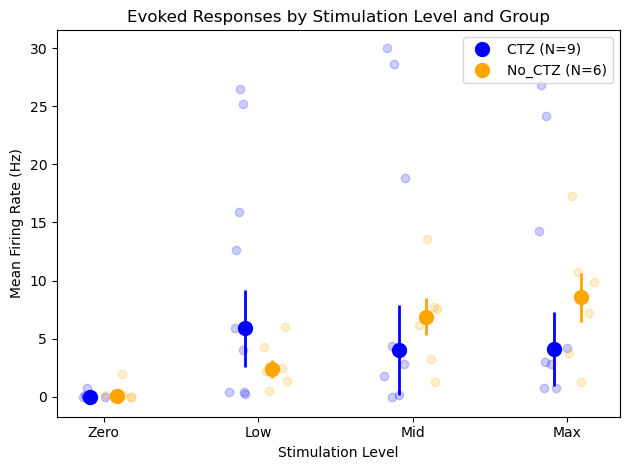

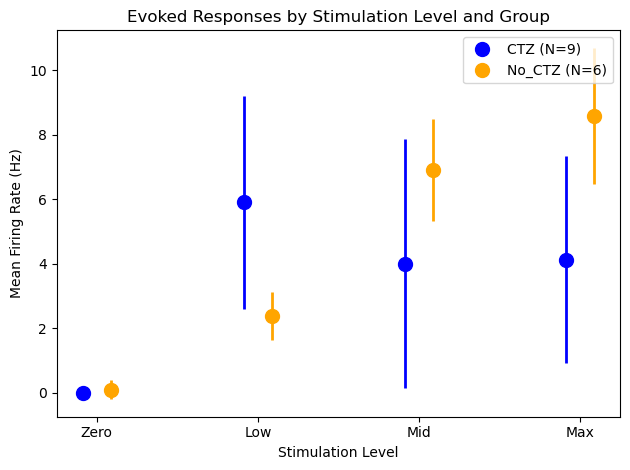

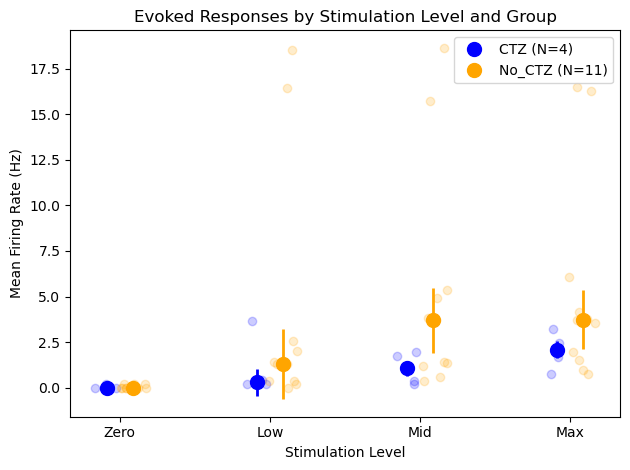

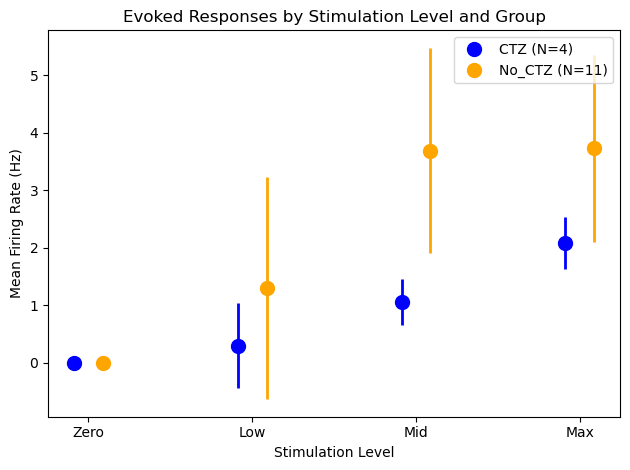

In [40]:

whisker_df_manager = DataFrameManager(whisker)
whisker_df_manager.eed
whisker_df_manager.create_dataframe(['Cell_Type', 'IsSingleUnit', 'StimResponsivity', 'MeanFR_baseline', 'MeanFR_stim','LaminarLabel', 'PeakEvokedFR', 'PeakEvokedFR_Latency', 'FanoFactor_baseline', 'FanoFactor_stim', 'SpikeTimes_all', 'MeanFR_inst_stim' ], 'basic_metrics')

###fast spiking single units 
fastspiking_df = whisker_df_manager.get_filtered_data('basic_metrics', is_single_unit=True,  cell_type='FS', stim_responsivity=1.0)
#fastspiking_df = fastspiking_df[fastspiking_df['MeanFR_baseline'] > 0.01]
fastspiking_df = fastspiking_df[fastspiking_df['LaminarLabel'] == 'IG']
plot_evoked_responses_with_individual_points(fastspiking_df, group_col='groupname', data_col='MeanFR_inst_stim', jitter=0.1, plot_individual_points=True)
plot_evoked_responses_with_individual_points(fastspiking_df, group_col='groupname', data_col='MeanFR_inst_stim', jitter=0.1, plot_individual_points=False)


###regular spiking single units
reguralspiking_df = whisker_df_manager.get_filtered_data('basic_metrics', is_single_unit=True, cell_type='RS', stim_responsivity=1.0)
#reguralspiking_df = reguralspiking_df[reguralspiking_df['MeanFR_baseline'] > 0.01]
reguralspiking_df = reguralspiking_df[reguralspiking_df['LaminarLabel'] == 'IG']
plot_evoked_responses_with_individual_points(reguralspiking_df, group_col='groupname', data_col='MeanFR_inst_stim', jitter=0.1, plot_individual_points=True)
plot_evoked_responses_with_individual_points(reguralspiking_df, group_col='groupname', data_col='MeanFR_inst_stim', jitter=0.1, plot_individual_points=False)

In [69]:
#repeat for opto data
opto = ExtractEphysData('/Volumes/MannySSD/','all_data.mat')


In [170]:
opto_df_manager = DataFrameManager(opto)
opto_df_manager.eed
opto_df_manager.create_dataframe(['Cell_Type', 'IsSingleUnit', 'StimResponsivity', 'MeanFR_baseline', 'MeanFR_stim', 'PeakEvokedFR', 'PeakEvokedFR_Latency', 'FanoFactor_baseline', 'FanoFactor_stim'], 'basic_metrics')

In [171]:
opto_df_manager.dataframes['basic_metrics']

,groupname,recordingname,cid,Cell_Type,IsSingleUnit,StimResponsivity,MeanFR_baseline,MeanFR_stim,PeakEvokedFR,PeakEvokedFR_Latency,FanoFactor_baseline,FanoFactor_stim
0,CTZ,ctz_2303_1,cid119,RS,1.0,1.0,0.00823045267489712,2.016460905349794,8.581514184678785,78.0,0.9999999999999996,0.993543916577941
1,CTZ,ctz_2303_1,cid184,RS,1.0,1.0,0.00823045267489712,21.62962962962963,94.4759744196294,63.0,0.9999999999999996,0.9380225790448079
2,CTZ,ctz_2303_1,cid186,RS,0.0,1.0,0.03292181069958848,17.646090534979425,49.006337026380955,450.0,0.9999999999999998,0.9609289972404974
3,CTZ,ctz_2303_1,cid217,RS,1.0,1.0,0.07407407407407407,7.1193415637860085,25.32215224215713,209.0,0.9999999999999997,0.9812454152557571
4,CTZ,ctz_2303_1,cid238,FS,1.0,1.0,0.0,2.905349794238683,8.544799937794432,459.0,0.0,0.9930247933884296
...,...,...,...,...,...,...,...,...,...,...,...,...
392,No_CTZ,veh_3143_2,cid524,FS,0.0,1.0,0.4066390041493776,22.796680497925312,52.66744108720816,63.0,0.9988304093567254,0.9593754334859199
393,No_CTZ,veh_3143_2,cid8,RS,1.0,1.0,0.1078838174273859,5.875518672199171,28.57740150758699,217.0,1.0,0.9799261639048605
394,No_CTZ,veh_3143_2,cid85,RS,1.0,1.0,0.008298755186721992,1.0871369294605808,4.281352367710369,116.0,1.0000000000000002,0.9952153110047846
395,No_CTZ,veh_3143_2,cid93,RS,0.0,1.0,6.033195020746888,16.821576763485478,30.13793957937057,211.0,0.9915731912507042,0.9749715735152649


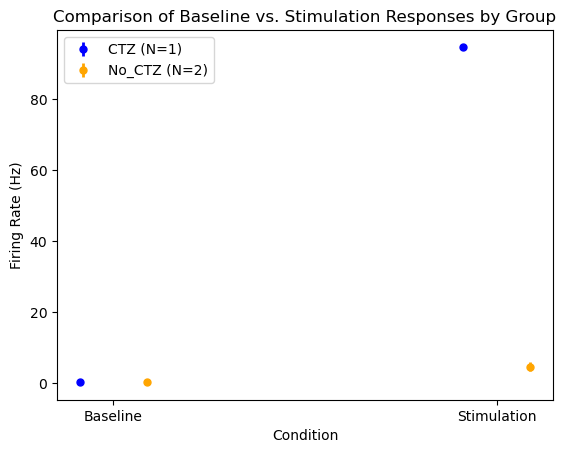

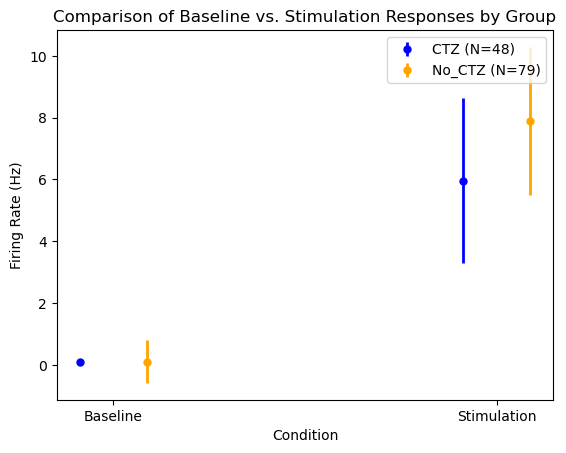

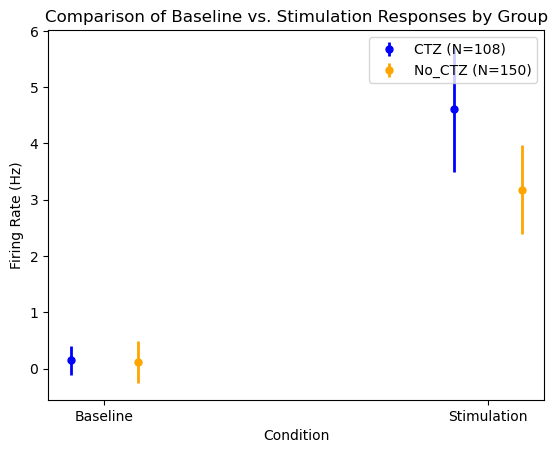

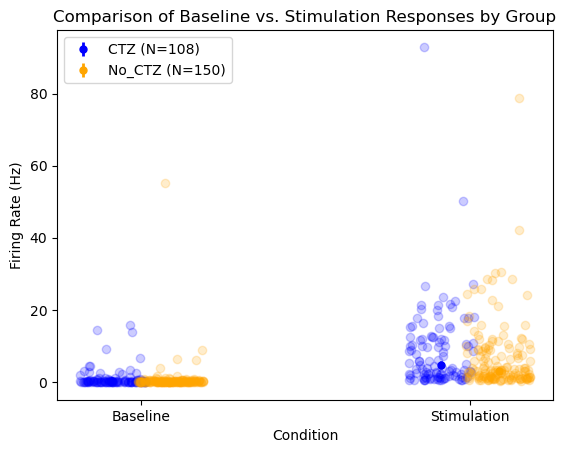

In [325]:
###fast spiking sua for opto 
fastspiking_opto_df = opto_df_manager.get_filtered_data('basic_metrics', is_single_unit=True,  cell_type='FS', stim_responsivity=1.0)
fastspiking_opto_df = fastspiking_opto_df[fastspiking_opto_df['MeanFR_baseline'] > 0.01]
plot_opto_stim_responses(fastspiking_opto_df, baseline_col='MeanFR_baseline', stim_col='PeakEvokedFR', jitter=0.1, plot_individual_points=False)


regularspiking_opto_df = opto_df_manager.get_filtered_data('basic_metrics', is_single_unit=True, cell_type='RS', stim_responsivity=1.0)
regularspiking_opto_df = regularspiking_opto_df[regularspiking_opto_df['MeanFR_baseline'] > 0.01]
plot_opto_stim_responses(regularspiking_opto_df, baseline_col='MeanFR_baseline', stim_col='PeakEvokedFR', jitter=0.1, plot_individual_points=False)

### mua activity 

mua_opto_df = opto_df_manager.get_filtered_data('basic_metrics', is_single_unit=None, cell_type=None, stim_responsivity=1.0)
mua_opto_df = mua_opto_df= mua_opto_df[mua_opto_df['MeanFR_baseline'] > .01]
#mua_opto_df = mua_opto_df= mua_opto_df[mua_opto_df['PeakEvokedFR_Latency'] < 500]
plot_opto_stim_responses(mua_opto_df, baseline_col='MeanFR_baseline', stim_col='MeanFR_stim', jitter=0.1, plot_individual_points=False)
plot_opto_stim_responses(mua_opto_df, baseline_col='MeanFR_baseline', stim_col='MeanFR_stim', jitter=0.1, plot_individual_points=True)




In [324]:
def compare_group_firing_rates_with_stats(df, group_col='groupname', baseline_col='MeanFR_baseline', stim_col='PeakEvokedFR'):
    """
    Performs Mann-Whitney U tests to compare baseline and stimulation firing rates between groups
    and includes descriptive statistics for each group.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data to analyze.
    group_col (str): Name of the column in df that contains group names.
    baseline_col (str): Name of the column in df that contains baseline firing rates.
    stim_col (str): Name of the column in df that contains peak evoked firing rates.

    Returns:
    pandas.DataFrame: A DataFrame with descriptive statistics and Mann-Whitney U test results.
    """
    # Group the DataFrame by 'groupname' and extract values
    grouped = df.groupby(group_col)

    group_stats = []
    for group_name, group_df in grouped:
        for condition in [baseline_col, stim_col]:
            # Extract values and compute statistics
            values = np.array([val.item() for val in group_df[condition] if isinstance(val, np.ndarray)])
            group_stats.append({
                'Group': group_name,
                'Condition': condition,
                'N': len(values),
                'Mean': np.mean(values),
                'Median': np.median(values),
                'SD': np.std(values)
            })

    stats_df = pd.DataFrame(group_stats)

    # Calculate Mann-Whitney U tests between groups
    test_results = []
    groups = list(grouped.groups.keys())
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            group1_name, group2_name = groups[i], groups[j]
            for condition in [baseline_col, stim_col]:
                data1 = np.array([val.item() for val in grouped.get_group(group1_name)[condition] if isinstance(val, np.ndarray)])
                data2 = np.array([val.item() for val in grouped.get_group(group2_name)[condition] if isinstance(val, np.ndarray)])
                stat, p_value = stats.mannwhitneyu(data1, data2, alternative='greater')
                
                test_results.append({
                    'Group1': group1_name,
                    'Group2': group2_name,
                    'Condition': condition,
                    'U-Statistic': stat,
                    'p-Value': p_value,
                    f'{group1_name} N': len(data1),
                    f'{group1_name} Mean': np.mean(data1),
                    f'{group1_name} Median': np.median(data1),
                    f'{group1_name} SD': np.std(data1),
                    f'{group2_name} N': len(data2),
                    f'{group2_name} Mean': np.mean(data2),
                    f'{group2_name} Median': np.median(data2),
                    f'{group2_name} SD': np.std(data2)
                })

    results_df = pd.DataFrame(test_results)
    return stats_df, results_df
#regularspiking_opto_df
stats_df, results_df = compare_group_firing_rates_with_stats(mua_opto_df, stim_col='MeanFR_stim')
results_df

,Group1,Group2,Condition,U-Statistic,p-Value,CTZ N,CTZ Mean,CTZ Median,CTZ SD,No_CTZ N,No_CTZ Mean,No_CTZ Median,No_CTZ SD
0,CTZ,No_CTZ,MeanFR_baseline,8726.5,0.144868,108,1.021426,0.144388,2.681520,150,0.756543,0.118852,4.572657
1,CTZ,No_CTZ,MeanFR_stim,9132.0,0.040542,108,8.674522,4.607038,11.508469,150,6.801078,3.175297,9.660372


In [313]:
def calculate_null_distribution(df, group_col='groupname', baseline_col='MeanFR_baseline', stim_col='PeakEvokedFR', n_permutations=1000):
    """
    Shuffles the data to create a null distribution for comparison of firing rates between groups.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data to analyze.
    group_col (str): Name of the column in df that contains group names.
    baseline_col (str): Name of the column in df that contains baseline firing rates.
    stim_col (str): Name of the column in df that contains peak evoked firing rates.
    n_permutations (int): Number of permutations to perform for the null distribution.

    Returns:
    pandas.DataFrame: A DataFrame with the observed statistics and their p-values against the null distribution.
    """
    results_list = []  # Use a list to collect dictionaries

    # Group the DataFrame by 'groupname'
    grouped = df.groupby(group_col)

    for group_name, group_df in grouped:
        for condition in [baseline_col, stim_col]:
            # Extract values and compute the observed mean
            values = np.array([val.item() for val in group_df[condition] if isinstance(val, np.ndarray)])
            observed_mean = np.mean(values)

            # Combine all values across groups for shuffling
            all_values = np.array([val.item() for _, gdf in grouped for val in gdf[condition] if isinstance(val, np.ndarray)])
            null_means = []

            # Perform shuffling n_permutations times
            for _ in range(n_permutations):
                np.random.shuffle(all_values)
                null_means.append(np.mean(all_values[:len(group_df)]))

            # Calculate p-value: proportion of null distribution means that are greater than the observed mean
            p_value = np.mean([null_mean >= observed_mean for null_mean in null_means])

            # Collect results in the list
            results_list.append({
                'Group': group_name,
                'Condition': condition,
                'Observed_Mean': observed_mean,
                'p-Value': p_value
            })

    # Convert the list of dictionaries to a DataFrame
    results_df = pd.DataFrame(results_list)

    return results_df

null_distribution_results = calculate_null_distribution(mua_opto_df, stim_col='MeanFR_stim')
null_distribution_results

,Group,Condition,Observed_Mean,p-Value
0,CTZ,MeanFR_baseline,4.977096,0.737
1,CTZ,MeanFR_stim,18.441647,0.496
2,No_CTZ,MeanFR_baseline,8.671193,0.285
3,No_CTZ,MeanFR_stim,18.140192,0.502


In [314]:
def permutation_test_for_stim_diff(df, group_col='groupname', stim_col='PeakEvokedFR', n_permutations=10000):
    """
    Performs a permutation test to compare the difference in stimulation firing rates between two groups.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data to analyze.
    group_col (str): Name of the column in df that contains group names.
    stim_col (str): Name of the column in df that contains peak evoked firing rates.
    n_permutations (int): Number of permutations to perform for the null distribution.

    Returns:
    float: The p-value from the permutation test.
    """
    # Split the data into two groups
    group1_df = df[df[group_col] == df[group_col].unique()[0]]
    group2_df = df[df[group_col] == df[group_col].unique()[1]]
    
    # Calculate the observed difference in means
    group1_data = np.array([val.item() for val in group1_df[stim_col] if isinstance(val, np.ndarray)])
    group2_data = np.array([val.item() for val in group2_df[stim_col] if isinstance(val, np.ndarray)])
    observed_diff = np.mean(group1_data) - np.mean(group2_data)
    
    # Combine all values across groups for shuffling
    all_values = np.concatenate((group1_data, group2_data))
    
    # Perform permutations
    null_diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(all_values)
        # After shuffling, split the values back into "groups" maintaining the original group sizes
        new_group1 = all_values[:len(group1_data)]
        new_group2 = all_values[len(group1_data):]
        # Calculate the difference in means for the permutation
        new_diff = np.mean(new_group1) - np.mean(new_group2)
        null_diffs.append(new_diff)

    # Calculate the p-value
    p_value = np.sum(np.abs(null_diffs) >= np.abs(observed_diff)) / n_permutations

    return p_value

# Usage example:
# Replace 'your_dataframe' with the actual DataFrame variable
p_value = permutation_test_for_stim_diff(mua_opto_df, stim_col='MeanFR_stim')
print(f"Permutation test p-value: {p_value}")

Permutation test p-value: 0.9716


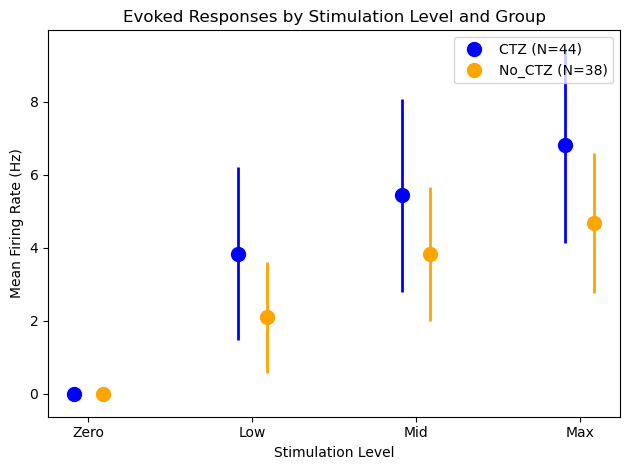

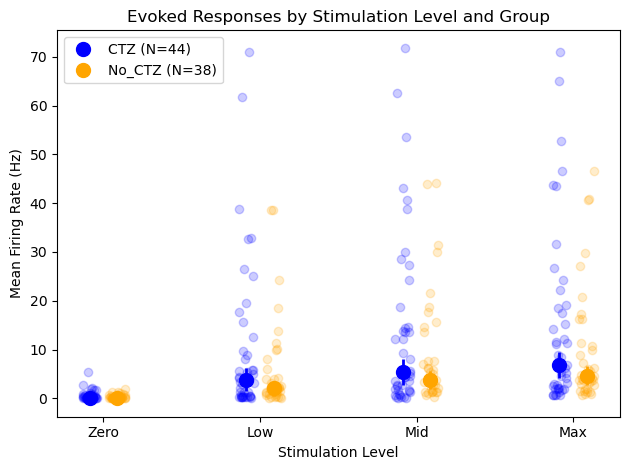

In [227]:
#multiunit activity for all cell types
mua_df = whisker_df_manager.get_filtered_data('basic_metrics', is_single_unit=None, cell_type=None, stim_responsivity=1.0)
mua_df= mua_df[mua_df['MeanFR_baseline'] > 0.01]
#mua_df= mua_df[mua_df['LaminarLabel'] == 'L4']

plot_evoked_responses_with_individual_points(mua_df, group_col='groupname', data_col='MeanFR_inst_stim', jitter=0.05, plot_individual_points=False)
plot_evoked_responses_with_individual_points(mua_df, group_col='groupname', data_col='MeanFR_inst_stim', jitter=0.05, plot_individual_points=True)



Original DataFrame size: 82
Filtered DataFrame size: 76
Number of rows removed: 6


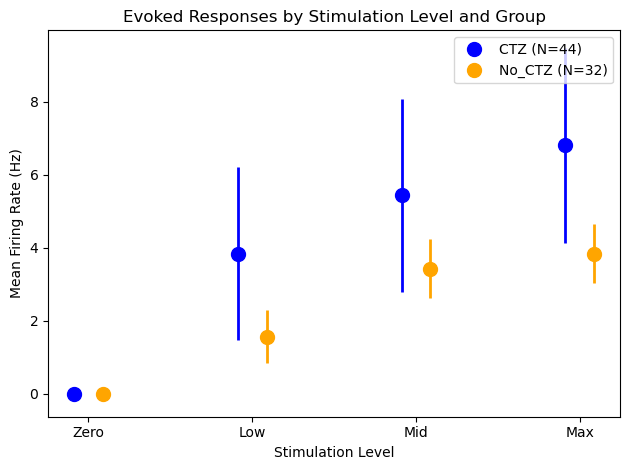

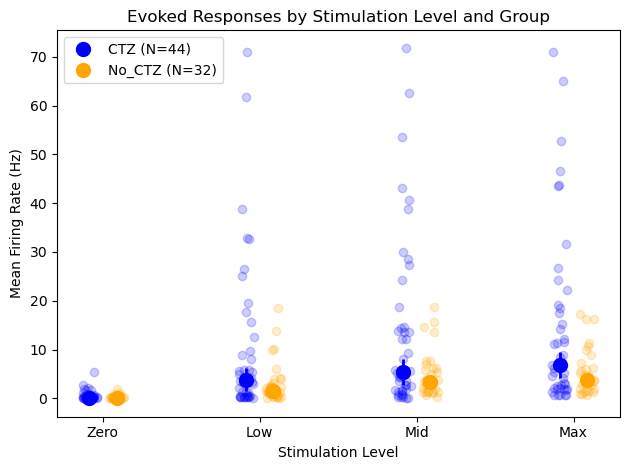

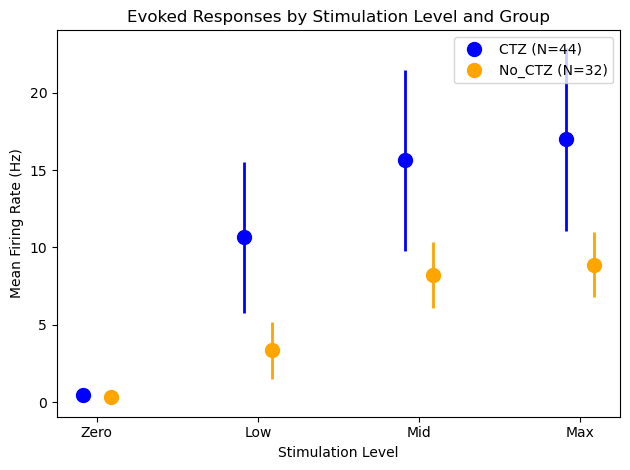

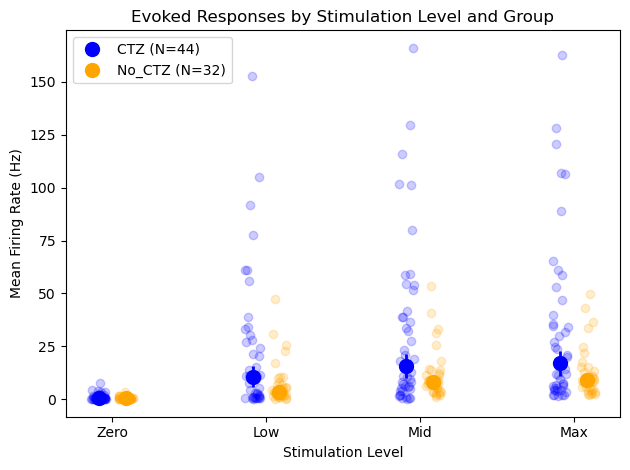

In [42]:
def remove_specific_points(df, group_col='groupname', mean_fr_col='MeanFR_inst_stim', threshold=20):
    """
    Remove entries from the 'No_CTZ' group where any of the last three firing rates exceed a threshold.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data.
    group_col (str): Column name for the group.
    mean_fr_col (str): Column name with lists of mean firing rates.
    threshold (float): The threshold value for the mean firing rate.

    Returns:
    pandas.DataFrame: The DataFrame with the specified data points removed.
    """
    # Define a mask for rows to remove
    condition = df.apply(lambda row: any(rate > threshold for rate in row[mean_fr_col][-3:]), axis=1) & (df[group_col] == 'No_CTZ')
    
    # Remove points that satisfy the condition
    filtered_df = df[~condition]
          
    return filtered_df

# Example usage of the function with printing of DataFrame sizes
original_size = mua_df.shape[0]  # Get the original number of rows
print(f"Original DataFrame size: {original_size}")

# Apply the function to remove specific points
updated_df = remove_specific_points(mua_df, threshold=20)
#fastspiking_df = remove_specific_points(fastspiking_df, threshold=20)
#reguralspiking_df = remove_specific_points(reguralspiking_df, threshold=20)


# Get the size after filtering
filtered_size = updated_df.shape[0]  # Get the new number of rows
print(f"Filtered DataFrame size: {filtered_size}")

# To see how many rows were removed
rows_removed = original_size - filtered_size
print(f"Number of rows removed: {rows_removed}")

plot_evoked_responses_with_individual_points(updated_df, group_col='groupname', data_col='MeanFR_inst_stim', jitter=0.05, plot_individual_points=False)
plot_evoked_responses_with_individual_points(updated_df, group_col='groupname', data_col='MeanFR_inst_stim', jitter=0.05, plot_individual_points=True)
plot_evoked_responses_with_individual_points(updated_df, group_col='groupname', data_col='PeakEvokedFR', jitter=0.05, plot_individual_points=False)
plot_evoked_responses_with_individual_points(updated_df, group_col='groupname', data_col='PeakEvokedFR', jitter=0.05, plot_individual_points=True)



In [ ]:

def count_cells_per_recording(df, group_col='groupname', recording_col='recordingname', cell_id_col='cid'):
    """
    Group the data by group name and count the number of unique cell identifiers (cid) for each recording.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data.
    group_col (str): Column name for the group.
    recording_col (str): Column name for the recording names.
    cell_id_col (str): Column name for the cell identifiers.

    Returns:
    pandas.DataFrame: A DataFrame with counts of cids per recording within each group.
    """
    # Group by group name and recording name, then count unique cids
    counts_df = df.groupby([group_col, recording_col])[cell_id_col].nunique().reset_index(name='Cell_Count')

    return counts_df

def filter_recordings_by_cell_count(df, min_cell_count, group_col='groupname', recording_col='recordingname', cell_id_col='cid'):
    """
    Filter out recordings that do not have at least a certain number of cells.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data.
    min_cell_count (int): The minimum number of cells required to keep a recording.
    group_col (str): Column name for the group.
    recording_col (str): Column name for the recording names.
    cell_id_col (str): Column name for the cell identifiers.

    Returns:
    pandas.DataFrame: The original DataFrame with recordings not meeting the cell count removed.
    """
    # Count the cells per recording using the previously defined function
    counts_df = count_cells_per_recording(df, group_col, recording_col, cell_id_col)
    
    # Filter for recordings with a cell count above the minimum threshold
    valid_recordings = counts_df[counts_df['Cell_Count'] >= min_cell_count]
    
    # Get a list of recording names that meet the criteria
    valid_recording_names = valid_recordings[recording_col].unique()
    
    # Filter the original dataframe to only include these recordings
    filtered_df = df[df[recording_col].isin(valid_recording_names)]

    return filtered_df, valid_recordings

# Usage example:
cell_counts_df = count_cells_per_recording(mua_df)
cell_counts_df
mua_df, valid_recordings = filter_recordings_by_cell_count(mua_df, min_cell_count=2)



In [ ]:
valid_recordings

In [11]:

!pip install scipy
!pip install statsmodels

from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import pandas as pd



In [46]:
def create_stimulation_dataframe(df, group_col, recording_col, cell_type_col, is_single_unit_col, stim_responsivity_col, stim_res_col, all_stim_labels):
    """
    Create a new DataFrame with specified columns and split stimulation response data.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the original data.
    group_col (str): Column name for the groups.
    recording_col (str): Column name for the recordings.
    cell_type_col (str): Column name for the cell type.
    is_single_unit_col (str): Column name for the single unit flag.
    stim_responsivity_col (str): Column name for the stimulation responsivity.
    stim_res_col (str): Column name for the stimulation response data.
    all_stim_labels (list): List of all stimulation labels to include.

    Returns:
    pandas.DataFrame: New DataFrame with the specified columns and separate columns for each stimulation level.
    """
    # Select only the essential columns
    new_df = df[[group_col, recording_col, cell_type_col, is_single_unit_col, stim_responsivity_col]].copy()

    # Split the stimulation response data into separate columns for each level
    for i, level in enumerate(all_stim_labels):
        new_df[level] = df[stim_res_col].apply(lambda x: x[i] if i < len(x) else None)
    
    return new_df

def kruskal_wallis_summary(df, group_col, recording_col, cell_type_col, is_single_unit_col, stim_responsivity_col, stim_res_col, all_stim_labels):
    """
    ... (existing docstring)
    """
    # Call the helper function to create a new DataFrame with stimulation columns
    new_df = create_stimulation_dataframe(df, group_col, recording_col, cell_type_col, is_single_unit_col, stim_responsivity_col, stim_res_col, all_stim_labels)

    # Initialize the results list
    summary_results = []

    # Get unique group names
    groups = new_df[group_col].unique()

    # Perform Kruskal-Wallis test and calculate summary statistics for each stimulation level
    for stim in all_stim_labels:
        # Dictionary to hold data for each group
        group_data_dict = {group: new_df[new_df[group_col] == group][stim].dropna() for group in groups}

        # Perform the Kruskal-Wallis test using the data for each group
        # Ensure there are at least two groups to compare
        if len(group_data_dict) >= 2:
            stat, p_value = kruskal(group_data_dict[groups[0]], group_data_dict[groups[1]])

            # Calculate summary statistics for each group
            group_summaries = {}
            for group in groups:
                group_summaries[f'Mean_{group}'] = group_data_dict[group].mean()
                group_summaries[f'Median_{group}'] = group_data_dict[group].median()
                group_summaries[f'SD_{group}'] = group_data_dict[group].std()
                group_summaries[f'Range_{group}'] = group_data_dict[group].max() - group_data_dict[group].min()

            # Compile results
            summary_results.append({
                'Stimulation': stim,
                'Statistic': stat,
                'p-value': p_value,
                **group_summaries
            })

    return pd.DataFrame(summary_results)

# Usage example:
all_stim_labels = ['Zero', 'Low', 'Mid', 'Max']
summary_df = kruskal_wallis_summary(updated_df, 'groupname', 'recordingname', 'Cell_Type', 'IsSingleUnit', 'StimResponsivity', 'PeakEvokedFR', all_stim_labels)
summary_df

,Stimulation,Statistic,p-value,Mean_CTZ,Median_CTZ,SD_CTZ,Range_CTZ,Mean_No_CTZ,Median_No_CTZ,SD_No_CTZ,Range_No_CTZ
0,Zero,0.793041,0.373182,0.935458,0.499185,1.525693,7.733253,0.480731,0.324423,0.717545,3.342116
1,Low,2.977018,0.084455,22.747069,10.646122,32.548497,152.604136,7.724809,3.355311,10.477723,47.187734
2,Mid,3.050030,0.080736,32.146667,15.643481,39.292997,166.069062,12.001202,8.195130,12.266174,52.701020
3,Max,3.274498,0.070364,33.018257,16.993039,39.616377,161.116811,12.905822,8.899423,12.230891,47.531153


In [ ]:
fastspiking_df_summary_df = kruskal_wallis_summary(fastspiking_df, 'groupname', 'recordingname', 'Cell_Type', 'IsSingleUnit', 'StimResponsivity', 'MeanFR_stim', all_stim_labels)
fastspiking_df_summary_df



In [ ]:
fastspiking_perm_test_df = permutation_test_with_helper(fastspiking_df, 'groupname', 'recordingname', 'Cell_Type', 'IsSingleUnit', 'StimResponsivity', 'MeanFR_stim', all_stim_labels)
fastspiking_perm_test_df

In [ ]:
reguralspiking_df_summary_df = kruskal_wallis_summary(reguralspiking_df, 'groupname', 'recordingname', 'Cell_Type', 'IsSingleUnit', 'StimResponsivity', 'MeanFR_stim', all_stim_labels)
reguralspiking_df_summary_df

In [ ]:
reguralspiking_perm_test_df= permutation_test_with_helper(fastspiking_df, 'groupname', 'recordingname', 'Cell_Type', 'IsSingleUnit', 'StimResponsivity', 'MeanFR_stim', all_stim_labels)
reguralspiking_perm_test_df


In [52]:
def permutation_test_with_helper(df, group_col, recording_col, cell_type_col, is_single_unit_col, stim_responsivity_col, stim_res_col, all_stim_labels, n_permutations=10000):
    """
    Create a new DataFrame with stimulation columns and then perform a permutation test
    across groups for each stimulation, calculating p-values.

    Parameters:
    df (pandas.DataFrame): Original DataFrame containing the data.
    group_col, recording_col, cell_type_col, is_single_unit_col, stim_responsivity_col: Column names for respective data.
    stim_res_col (str): Column name for the stimulation response data.
    all_stim_labels (list): List of all stimulation labels to include.
    n_permutations (int): Number of permutations to perform.

    Returns:
    pandas.DataFrame: Summary DataFrame containing the actual differences and p-values.
    """
    # Use the helper function to create a new DataFrame with stimulation columns
    stim_df = create_stimulation_dataframe(df, group_col, recording_col, cell_type_col, is_single_unit_col, stim_responsivity_col, stim_res_col, all_stim_labels)
    
    # Initialize the results list
    summary_results = []

    # Get unique group names
    groups = stim_df[group_col].unique()

    for stim in all_stim_labels:
        # Actual difference in medians between groups
        group_data = [stim_df[stim_df[group_col] == group][stim].dropna() for group in groups]
        actual_diff = abs(group_data[0].median() - group_data[1].median())

        # Initialize permutation distribution
        perm_diffs = []

        for _ in range(n_permutations):
            # Shuffle the data within each stimulation column
            permuted_data = np.random.permutation(np.concatenate(group_data))

            # Split the data back into two groups
            perm_group1 = permuted_data[:len(group_data[0])]
            perm_group2 = permuted_data[len(group_data[0]):]

            # Calculate the difference in medians for this permutation
            perm_diffs.append(abs(np.median(perm_group1) - np.median(perm_group2)))

        # Calculate the p-value
        p_value = np.mean(np.array(perm_diffs) >= actual_diff)

        # Compile results
        summary_results.append({
            'Stimulation': stim,
            'Actual Difference': actual_diff,
            'p-value': p_value
        })

    return pd.DataFrame(summary_results)

# Usage example:
all_stim_labels = ['Zero', 'Low', 'Mid', 'Max']
perm_test_df = permutation_test_with_helper(updated_df, 'groupname', 'recordingname', 'Cell_Type', 'IsSingleUnit', 'StimResponsivity', 'PeakEvokedFR', all_stim_labels)
perm_test_df


,Stimulation,Actual Difference,p-value
0,Zero,0.174762,0.6473
1,Low,7.290811,0.0235
2,Mid,7.448352,0.0351
3,Max,8.093616,0.0497


PeakEvokedFR	PeakEvokedFR_Latency	FanoFactor_baseline	FanoFactor_stim

In [ ]:
#repeat the above but for the first of the group, recording, cell ID
def print_structure(EED):
    
    print(f'There are {len(EED.all_data.keys())} experimental groups in the first level')
    print(f'Keys in all_data that correspond to the experimetnal groups in the first level: {EED.all_data.keys()}')
    
    for groupname in EED.all_data.keys(): #loop through the first level = experimental groups
        print(f'Keys in experimental group {groupname}: {EED.all_data[groupname].keys()}')
        #print the total number of keys in the first level
        print(f'Length of {groupname}: {len(EED.all_data[groupname].keys())}')
        
        for recordingname in EED.all_data[groupname].keys(): #loop through the second level = recordings in the experimental group per animal
            print(f'Keys in {groupname}/{recordingname} represent the unique cell IDs (cid) {EED.all_data[groupname][recordingname].keys()}')
            for cid in EED.all_data[groupname][recordingname].keys(): #loop through the third level = the data for each cell ID (cid)
                print(f'Keys in {groupname}/{recordingname}/{cid} represent the stores data {EED.all_data[groupname][recordingname][cid].keys()}')
                print(f'{groupname}/{recordingname}/{cid} has a total of {len(EED.all_data[groupname][recordingname][cid].keys())} keys in the third level containing the data')
                for fieldname in EED.all_data[groupname][recordingname][cid].keys(): #loop through the fourth level = the data for each fieldname 
                    print(f'Data type of {fieldname}: {type(EED.all_data[groupname][recordingname][cid][fieldname])}')
                    break
                break
            break
        break
    return

#run the function

print_structure(EED)

def create_dataframe_from_nested_dict(EED, columns):
    data = []  # List to store each row of data
    # Iterate over experimental groups
    for groupname, recordings in EED.all_data.items():
        # Iterate over recordings within an experimental group
        for recordingname, cells in recordings.items():
            # Iterate over each cell in a recording
            for cid, metrics in cells.items():
                # Create a row dictionary starting with groupname, recordingname, and cid
                row = {'groupname': groupname, 'recordingname': recordingname, 'cid': cid}
                
                # Add additional columns specified by the user
                for column in columns:
                    row[column] = metrics.get(column, None)  # Use None if key is not found
                
                # Append the row dictionary to the data list
                data.append(row)

    # Create DataFrame from the list of row data
    return pd.DataFrame(data)

desired_columns = ['Cell_Type', 'IsSingleUnit', 'MeanFR_baseline', 'LaminarLabel']
df = create_dataframe_from_nested_dict(EED, desired_columns)
df


In [ ]:
#print the group names with the desctiption of the data
print(f'Group names: {EED.group_names}')

print(f'Recordings: {EED.recordings}')

#create a function where the outline of the structure is is clearly outline up to the third level
def print_structure(EED):
    
    print(f'There are {len(EED.all_data.keys())} experimental groups in the first level')
    print(f'Keys in all_data that correspond to the experimetnal groups in the first level: {EED.all_data.keys()}')
    
    for groupname in EED.all_data.keys(): #loop through the first level = experimental groups
        print(f'Keys in experimental group {groupname}: {EED.all_data[groupname].keys()}')
        #print the total number of keys in the first level
        print(f'Length of {groupname}: {len(EED.all_data[groupname].keys())}')
        
        for recordingname in EED.all_data[groupname].keys(): #loop through the second level = recordings in the experimental group per animal
            print(f'Keys in {groupname}/{recordingname} represent the unique cell IDs (cid) {EED.all_data[groupname][recordingname].keys()}')
            for cid in EED.all_data[groupname][recordingname].keys(): #loop through the third level = the data for each cell ID (cid)
                print(f'Keys in {groupname}/{recordingname}/{cid} represent the stores data {EED.all_data[groupname][recordingname][cid].keys()}')
                print(f'{groupname}/{recordingname}/{cid} has a total of {len(EED.all_data[groupname][recordingname][cid].keys())} keys in the third level containing the data')
                for fieldname in EED.all_data[groupname][recordingname][cid].keys(): #loop through the fourth level = the data for each fieldname 
                    print(f'Data type of {fieldname}: {type(EED.all_data[groupname][recordingname][cid][fieldname])}')
                               
    return 

#repeat the above but for the first of the group, recording, cell ID
def print_structure(EED):
    
    print(f'There are {len(EED.all_data.keys())} experimental groups in the first level')
    print(f'Keys in all_data that correspond to the experimetnal groups in the first level: {EED.all_data.keys()}')
    
    for groupname in EED.all_data.keys(): #loop through the first level = experimental groups
        print(f'Keys in experimental group {groupname}: {EED.all_data[groupname].keys()}')
        #print the total number of keys in the first level
        print(f'Length of {groupname}: {len(EED.all_data[groupname].keys())}')
        
        for recordingname in EED.all_data[groupname].keys(): #loop through the second level = recordings in the experimental group per animal
            print(f'Keys in {groupname}/{recordingname} represent the unique cell IDs (cid) {EED.all_data[groupname][recordingname].keys()}')
            for cid in EED.all_data[groupname][recordingname].keys(): #loop through the third level = the data for each cell ID (cid)
                print(f'Keys in {groupname}/{recordingname}/{cid} represent the stores data {EED.all_data[groupname][recordingname][cid].keys()}')
                print(f'{groupname}/{recordingname}/{cid} has a total of {len(EED.all_data[groupname][recordingname][cid].keys())} keys in the third level containing the data')
                for fieldname in EED.all_data[groupname][recordingname][cid].keys(): #loop through the fourth level = the data for each fieldname 
                    print(f'Data type of {fieldname}: {type(EED.all_data[groupname][recordingname][cid][fieldname])}')
                    break
                break
            break
        break
    return

#run the function

print_structure(EED)



output = print_structure(EED) 
output

#make a function that access the first group, first recording, first cell ID and first fieldname to find the data type of the fieldname
def find_data_type(EED):
    groupname = list(EED.all_data.keys())[0]
    recordingname = list(EED.all_data[groupname].keys())[0]
    cid = list(EED.all_data[groupname][recordingname].keys())[0]
    fieldname = list(EED.all_data[groupname][recordingname][cid].keys())[0]
    print(f'Groupname: {groupname}')
    print(f'Recordingname: {recordingname}')
    print(f'Cell ID: {cid}')
    print(f'Fieldname: {fieldname}')
    fieldname_data = EED.all_data[groupname][recordingname][cid][fieldname]
    fieldname_type = type(EED.all_data[groupname][recordingname][cid][fieldname])
    
    
    
    #retrieve the data 
    return fieldname_type, fieldname_data

_ , data = find_data_type(EED)

#create a function that users a fieldname as an input and returns the data type of the fieldname 
def find_data_type_fieldname(EED, fieldname):
    
    groupname = list(EED.all_data.keys())[0]
    recordingname = list(EED.all_data[groupname].keys())[0]
    cid = list(EED.all_data[groupname][recordingname].keys())[0]
    fieldname_data = EED.all_data[groupname][recordingname][cid][fieldname]
    fieldname_type = type(EED.all_data[groupname][recordingname][cid][fieldname])
    return fieldname_type, fieldname_data 

#repeat the above but it ensures to return a datframe where group, recording, cell ID and fieldname are included 
def find_data_type_fieldname(EED, fieldname):
    
    groupname = list(EED.all_data.keys())[0]
    recordingname = list(EED.all_data[groupname].keys())[0]
    cid = list(EED.all_data[groupname][recordingname].keys())[0]
    fieldname_data = EED.all_data[groupname][recordingname][cid][fieldname]
    fieldname_type = type(EED.all_data[groupname][recordingname][cid][fieldname])
    data = pd.DataFrame({'Group': groupname, 'Recording': recordingname, 'Cell ID': cid, 'Fieldname': fieldname})
    return fieldname_type, data



Everythimg after here is old LMC stuff so dont remove 

In [ ]:
# Initialize the class with the path to your .mat file
EED = ExtractEphysData('/Users/cresp1el/Documents/MATLAB/lmc_20ms_data.mat')

stimulation_data = EED.get_stimulation_data() #get stimulation data for all recordings in all groups in a dictionary with unit ids as keys 
converted_data = EED.reorganize_stimulation_data(stimulation_data) #reorganize the stimulation data in a dictionary with group names as keys and lists of dictionaries with unit ids as values

EED.create_trial_intensity_dataframe(converted_data) #create a dataframe with the trial intensity for all recordings in all groups and save it as an attribute of the class

xarrays = EED.create_xarray(converted_data) #create an xarray with the trial intensity for all recordings in all groups and save it as an attribute of the class 

xarrys_ms = EED.convert_sample_to_time(xarrays)
xarrys_ms

In [ ]:
import xarray as xr

def extract_spike_counts_per_intensity_in_window(xarrays_dict, window_of_interest_ms):
    """
    Extracts and aggregates spike counts and firing rates from neural data within a specified time window for different stimulation intensities.

    This function processes a dictionary of xarray DataArray objects representing neural spike data. It extracts the spike counts and calculates the firing rates within a specified time window for different stimulus intensities. The stimulus intensities are determined from an attribute in the xarray objects. The extracted data is structured in a nested dictionary format.

    Parameters:
    xarrays_dict (dict): A dictionary where the keys are unit_ids and the values are xarray DataArray objects. Each DataArray object contains neural spike data with dimensions of 'Trial_ID' and 'Time', and an attribute 'Intensity' representing stimulus intensities.
    window_of_interest_ms (tuple): A tuple specifying the start and end of the time window in milliseconds for which the spike counts and firing rates should be extracted.

    Returns:
    dict: A nested dictionary where the outer dictionary has unit_ids as keys and dictionaries as values. The inner dictionaries have stimulus intensities (1 to 4) as keys and lists of tuples as values. Each tuple contains the trial ID (str), the number of spikes in the specified window (int), and the firing rate (float) in spikes per second.

    Usage:
    - Ensure to have a dictionary of xarray DataArray objects with the necessary dimensions and attribute.
    - Specify the time window of interest in milliseconds.
    - Call this function with the dictionary of xarray objects and the time window to get the extracted spike data.

    Example:
    spike_data = extract_spike_counts_per_intensity_in_window(xarrays_dict, (500, 525))
    """
    spike_data = {}

    # Loop through each unit_id in the dictionary
    for unit_id, data in xarrays_dict.items():
        
        # Find the indices of the time dimension corresponding to the specified time window
        time_indices = (data.coords['Time'] >= window_of_interest_ms[0]) & (data.coords['Time'] <= window_of_interest_ms[1])

        # Calculate the duration of the time window in seconds
        window_duration_s = (window_of_interest_ms[1] - window_of_interest_ms[0]) / 1000.0
        
        # Get the intensity attribute as a DataArray
        intensity_dataarray = xr.DataArray(data.attrs['Intensity'], dims='Trial_ID', coords={'Trial_ID': data.coords['Trial_ID']})

        # Initialize a dictionary to store the spike counts and firing rates for different stimulation intensities
        spike_data_per_intensity = {}

        # Loop through each stimulation intensity level
        for intensity in range(1, 5):
            
            # Get the trials corresponding to the current stimulation intensity
            trial_ids = intensity_dataarray[intensity_dataarray == intensity].coords['Trial_ID'].values
            trials = data.sel(Trial_ID=trial_ids)
            
            # Count the number of spikes in the specified time window for each trial and calculate the firing rate
            spike_info = [(trial_id, trial_data.sum().item(), trial_data.sum().item() / window_duration_s) for trial_id, trial_data in zip(trial_ids, trials[:, time_indices])]
            
            # Add the spike info list to the spike_data_per_intensity dictionary with intensity as the key
            spike_data_per_intensity[intensity] = spike_info
        
        # Add the spike data dictionary to the output dictionary
        spike_data[unit_id] = spike_data_per_intensity

    return spike_data



extracted_spiked_for_earlyphase = extract_spike_counts_per_intensity_in_window(xarrys_ms, (500, 525))
extracted_spiked_for_earlyphase['0c46c31c86790ba4e5a40aa6205e0a0b0931294445106f8437eb442c2b4669ac']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spike_count_distribution_per_stim_intensity(spike_data, exclude_zeros=False):
    """
    Plot the distribution of spike counts per stimulus intensity in a 1x4 subplot layout.

    This function takes the output of the `extract_spike_data` function, which is a nested dictionary containing spike counts and firing rates per trial, to plot the distribution of spike counts in 1x4 subplot layout for each unit ID present in the spike data dictionary.

    Parameters:
    spike_data (dict): A dictionary with unit_ids as keys and dictionaries as values. The inner dictionary has stimulus intensities (1 to 4) as keys and lists of tuples as values. Each tuple contains the trial ID (str), the number of spikes in the specified window (int), and the firing rate (float) in spikes per second.
    exclude_zeros (bool, optional): A boolean flag to determine whether to exclude zero spike counts from the histograms. Defaults to False, including zero spike counts in the histograms.

    Returns:
    None: This function displays the plots and does not return any values.

    Usage:
    - Ensure to have a dictionary obtained from the `extract_spike_data` function.
    - Call this function with the spike data dictionary and optionally set `exclude_zeros` to True to exclude zero spike counts from the histograms.
    
    Example:
    plot_spike_count_distribution_per_stim_intensity(spike_data, exclude_zeros=True)
    """
    # Loop through each unit_id in the spike data dictionary
    for unit_id, unit_data in spike_data.items():
        
        # Create a 1x4 subplot layout
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # Set a main title for the unit_id
        fig.suptitle(f'Unit ID: {unit_id}', fontsize=16)
        
        # Loop through each stimulation intensity level and plot the histogram of spike counts
        for intensity in range(1, 5):
            # Get the spike counts for the current stimulation intensity
            spike_counts = [x[1] for x in unit_data[intensity] if not (exclude_zeros and x[1] == 0)]
            
            # Calculate the histogram using numpy to have exact spike count bins
            hist, bin_edges = np.histogram(spike_counts, bins=range(17))
            
            # Plot the histogram as a bar plot with exact spike count bins
            axes[intensity-1].bar(bin_edges[:-1], hist, width=1, edgecolor='black', alpha=0.7)
            axes[intensity-1].set_title(f'Stimulus Intensity {intensity}')
            axes[intensity-1].set_xlabel('Number of spikes')
            axes[intensity-1].set_ylabel('Frequency')
        
        # Display the plot
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()


plot_spike_count_distribution_per_stim_intensity(extracted_spiked_for_earlyphase, exclude_zeros=True)

In [ ]:
xarrys_ms

In [ ]:
import xarray as xr

def extract_conditioned_spike_data(data_dict, window_of_interest_ms):
    """
    Extracts spike counts and firing rates within a specified time window for different conditions.

    Parameters:
    data_dict (dict): A nested dictionary with outer keys being unit IDs and inner keys representing different conditions (combinations of intensity and optionally epoch), and values being xarray DataArrays objects containing the data for those conditions.
    window_of_interest_ms (tuple): A tuple specifying the start and end of the time window in milliseconds for which the spike counts and firing rates should be extracted.

    Returns:
    dict: A nested dictionary where the outer dictionary has unit_ids as keys and dictionaries as values. The inner dictionaries have conditions as keys and lists of tuples as values. Each tuple contains the trial ID (str), the number of spikes in the specified window (int), and the firing rate (float) in spikes per second.
    """
    spike_data = {}

    # Loop through each unit_id in the dictionary
    for unit_id, conditions_data in data_dict.items():

        # Initialize a dictionary to store the spike counts and firing rates for different conditions
        spike_data_per_condition = {}

        # Loop through each condition
        for condition, data in conditions_data.items():
            
            # Find the indices of the time dimension corresponding to the specified time window
            time_indices = (data.coords['Time'] >= window_of_interest_ms[0]) & (data.coords['Time'] <= window_of_interest_ms[1])

            # Calculate the duration of the time window in seconds
            window_duration_s = (window_of_interest_ms[1] - window_of_interest_ms[0]) / 1000.0

            # Get the trial IDs
            trial_ids = data.coords['Trial_ID'].values

            # Count the number of spikes in the specified time window for each trial and calculate the firing rate
            spike_info = [(str(trial_id.values), trial_data.sum().item(), trial_data.sum().item() / window_duration_s) for trial_id, trial_data in zip(data['Trial_ID'], data[:, time_indices])]

            # Add the spike info list to the spike_data_per_condition dictionary with the condition as the key
            spike_data_per_condition[condition] = spike_info

        # Add the spike data dictionary to the output dictionary
        spike_data[unit_id] = spike_data_per_condition

    return spike_data


extracted_spiked_for_earlyphase_cond = extract_conditioned_spike_data(output_test, (500, 525))
extracted_spiked_for_earlyphase_cond['0c46c31c86790ba4e5a40aa6205e0a0b0931294445106f8437eb442c2b4669ac']


In [ ]:
extracted_spiked_for_earlyphase_cond

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_spike_histograms_per_stim_and_epoch(spike_data, bin_edges, exclude_zero_spikes=False):
    """
    Plots histograms of spike counts for different stimulus types and epochs.

    Parameters:
    spike_data (dict): The output from the `extract_conditioned_spike_data` function, a nested dictionary with spike counts and firing rates for each condition.
    bin_edges (list or array-like): The bin edges to use for the histograms.
    exclude_zero_spikes (bool): Whether to exclude trials with zero spikes from the histograms. Default is False.

    """
    # Define stimulus types and epochs
    stimulus_types = ['Zero', 'Low', 'Mid', 'Max']
    epochs = ['_Pre', '_Post']
    
    # Define colors for each epoch for visualization
    epoch_colors = {'_Pre': 'grey', '_Post': 'blue'}
    
    # Loop through each unit_id in the spike_data
    for unit_id, conditions_data in spike_data.items():
        
        # Create 1x4 subplots
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # Loop through each stimulus type and plot the data for both Pre and Post epochs
        for i, stimulus_type in enumerate(stimulus_types):
            
            # Get the current axis
            ax = axes[i]
            
            # Plot histograms for both Pre and Post epochs
            for epoch in epochs:
                condition = stimulus_type + epoch
                
                # Get the spike counts for all trials in the current condition
                spike_counts = [x[1] for x in conditions_data.get(condition, [])]
                
                # Optionally exclude trials with zero spikes
                if exclude_zero_spikes:
                    spike_counts = [count for count in spike_counts if count > 0]
                
                # Plot the histogram with specified bin edges
                ax.hist(spike_counts, bins=bin_edges, edgecolor=epoch_colors[epoch], histtype='step')
        
        # Add labels
        for ax in axes:
            ax.set_xlabel('Spike Count')
            ax.set_ylabel('Frequency')
        
        # Adjust layout to prevent overlapping
        plt.tight_layout()
        
        # Show the plot
        plt.show()



plot_spike_histograms_per_stim_and_epoch(extracted_spiked_for_earlyphase_cond, bin_edges=list(range(0, 16)), exclude_zero_spikes=True)

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_spike_histograms(spike_data, exclude_zero_spikes=False, pool_units=False):
    """
    Plots histograms of spike counts for different stimulus types and epochs.

    Parameters:
    spike_data (dict): Nested dictionary with spike counts and firing rates for each condition.
    exclude_zero_spikes (bool): Whether to exclude trials with zero spikes. Default is False.
    pool_units (bool): Whether to pool all unit IDs onto the same set of subplots. Default is False.

    """
    # Define stimulus types and epochs
    stimulus_types = ['Zero', 'Low', 'Mid', 'Max']
    epochs = ['_Pre', '_Post']
    
    # Define colors for each epoch for visualization
    epoch_colors = {'_Pre': 'grey', '_Post': 'blue'}
    
    # Define bin edges to represent exact integer spike counts from 0 to 15
    bin_edges = list(range(0, 17))
    
    if pool_units:
        # Create a dictionary to store pooled spike counts
        pooled_spike_counts = {stimulus_type + epoch: [] for stimulus_type in stimulus_types for epoch in epochs}

        # Loop through each unit_id in the spike_data to pool the data
        for unit_id, conditions_data in spike_data.items():
            for stimulus_type in stimulus_types:
                for epoch in epochs:
                    condition = stimulus_type + epoch
                    
                    # Get the spike counts for all trials in the current condition
                    spike_counts = [x[1] for x in conditions_data.get(condition, [])]
                    
                    # Optionally exclude trials with zero spikes
                    if exclude_zero_spikes:
                        spike_counts = [count for count in spike_counts if count > 0]
                    
                    # Add the spike counts to the pooled data
                    pooled_spike_counts[condition].extend(spike_counts)

        # Create 1x4 subplots for the pooled data
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # Plot the pooled data
        for i, stimulus_type in enumerate(stimulus_types):
            for epoch in epochs:
                condition = stimulus_type + epoch
                
                # Get the spike counts for the current condition
                spike_counts = pooled_spike_counts[condition]
    
                # Get the histogram values using np.histogram
                hist_values, _ = np.histogram(spike_counts, bins=bin_edges)
                
                # Plot the histogram using plt.step
                axes[i].step(bin_edges[:-1], hist_values, where='post', color=epoch_colors[epoch])

    else:
        # Loop through each unit_id in the spike_data to plot individually
        for unit_id, conditions_data in spike_data.items():
            
            # Create 1x4 subplots for individual units
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
            
            # Plot the data for individual units
            for i, stimulus_type in enumerate(stimulus_types):
                for epoch in epochs:
                    condition = stimulus_type + epoch
                    
                    # Get the spike counts for all trials in the current condition
                    spike_counts = [x[1] for x in conditions_data.get(condition, [])]
                    
                    # Optionally exclude trials with zero spikes
                    if exclude_zero_spikes:
                        spike_counts = [count for count in spike_counts if count > 0]

                    # Get the histogram values using np.histogram
                    hist_values, _ = np.histogram(spike_counts, bins=bin_edges)
                    
                    # Plot the histogram using plt.step
                    axes[i].step(bin_edges[:-1], hist_values, where='post', color=epoch_colors[epoch])
            
            # Adjust layout to prevent overlapping
            plt.tight_layout()

            # Show the plot for the current unit
            plt.show()
            
            # Close the figure to free up memory
            plt.close(fig)




plot_spike_histograms(extracted_spiked_for_earlyphase_cond, exclude_zero_spikes=False, pool_units=True)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt

def plot_raster(EED, xarrays, unit_id):
    """
    Plots a raster plot for a single unit, with the color of the spike events indicating the epoch they occurred in (Pre or Post).
    
    Parameters:
    - EED (object): The EED instance containing the experiment data.
    - xarrays (dict): Dictionary containing xarray DataArrays with neural data.
    - unit_id (str): The ID of the unit to plot.

    Returns:
    - None
    """
    # Get the unit metadata
    unit_metadata = EED.unit_id_map[unit_id]
    
    # Get the data for the specified unit
    data = xarrays[unit_id]

    # Get trial epochs and create a color map to differentiate spikes based on epoch
    trial_epochs = EED.trial_intensity_dataframes[unit_id]['Epoch']
    epoch_colors = {'Pre': 'grey', 'Post': 'blue'}
    
    # Create the raster plot
    plt.figure()
    plt.title(f"Raster Plot - {' > '.join(unit_metadata['path'])}")
    
    time_values = data.coords['Time'].values
    
    for trial_id, trial_data in data.groupby('Trial_ID'):
        spike_times = time_values[trial_data.values[0, :].astype(bool)]
        
        # Get the index of the trial ID to use in the color map
        trial_idx = data.Trial_ID.to_index().get_loc(trial_id)
        
        # Get the epoch of the trial to determine the color of the spikes
        trial_epoch = trial_epochs.iloc[trial_idx]
        trial_color = epoch_colors[trial_epoch]
        
        plt.scatter(spike_times, [trial_idx]*len(spike_times), c=trial_color, marker='|')
    
    plt.xlabel('Time (ms)')
    plt.ylabel('Trial')
    plt.axvline(x=500, color='red', linestyle='--')  # Stimulus onset
    plt.show()


# Plot the raster plot for a single unit
plot_raster(EED, xarrys_ms, '9fc0d2767bd8cd4ae04ad00b6347491b44e8e9553968a155f383c9ee43aee73a')

In [ ]:
def categorize_trials_by_conditions(EED, xarrays, separate_by_epoch=True):
    """
    Categorizes trials by different conditions (intensity and optionally epoch) and prepares data for further analyses or plotting.

    Parameters:
    - EED (object): The EED instance containing the experiment data.
    - xarrays (dict): Dictionary containing xarray DataArrays with neural data.
    - separate_by_epoch (bool): Whether to separate the data by epoch in addition to intensity.

    Returns:
    - dict: A nested dictionary with outer keys being unit IDs and inner keys representing different conditions 
            (combinations of intensity and optionally epoch), and values being xarray DataArrays containing the data for those conditions.
    """
    # Mapping of intensity values to their respective labels
    intensity_mapping = {1: 'Zero', 2: 'Low', 3: 'Mid', 4: 'Max'}

    # Create a dictionary to store data categorized by condition
    data_by_condition = {}

    # Iterating through all combinations of epochs and intensities
    for unit_id, xarray in xarrays.items():
        data_by_condition[unit_id] = {}
        for epoch in (['Pre', 'Post'] if separate_by_epoch else [None]):
            for intensity_value, intensity_label in intensity_mapping.items():
                # Create a unique key for this condition
                condition_key = f"{intensity_label}_{epoch}" if epoch else intensity_label
                
                # Use the query_units method to get the data for this condition
                condition_data = EED.query_units(xarrays, [unit_id], intensity=intensity_label, epoch=epoch)[unit_id]
                
                # Store this data in the dictionary
                data_by_condition[unit_id][condition_key] = condition_data

    return data_by_condition



unit_id = ['c8f5e0605522dfc696ff79b9782300ad3a90175ad0f6e910274d968d39c082e4', '69d625b1ee3dd0d024ae59d92baeb60d2eee6295663dbc4d80b58e344681825a']
output_test = categorize_trials_by_conditions(EED, xarrys_ms, separate_by_epoch=True)


In [ ]:
output_test

In [ ]:
output_test

In [ ]:
# Example usage to get data for a specific unit with 'Mid' intensity during the 'Pre' epoch
queried_data = EED.query_units(xarrys_ms, ['9fc0d2767bd8cd4ae04ad00b6347491b44e8e9553968a155f383c9ee43aee73a'], intensity=None, epoch=None)
queried_data['9fc0d2767bd8cd4ae04ad00b6347491b44e8e9553968a155f383c9ee43aee73a']
xr_data = queried_data['9fc0d2767bd8cd4ae04ad00b6347491b44e8e9553968a155f383c9ee43aee73a']

In [ ]:
# Assign a temporary name to the DataArray (replace 'temp_name' with an appropriate name)
xr_data.name = 'temp_name'

# Print basic information about the xarray
print("Xarray Information:")
print(xr_data)

# Print the dimensions of the xarray
print("\nDimensions:")
print(xr_data.dims)

# Print coordinate information
print("\nCoordinates:")
print(xr_data.coords)

# Print attributes of the xarray
print("\nAttributes:")
print(xr_data.attrs)

# Print a summary of the xarray's data
print("\nData Summary:")
print(xr_data.to_dataframe().describe())



In [ ]:
# Assuming your spike data is in the 'xr_data' variable

# Create a figure and axis for the raster plot
fig, ax = plt.subplots(figsize=(5, 5))

# Get the trial IDs, intensity, and epoch information from the DataFrame
df = EED.trial_intensity_dataframes['9fc0d2767bd8cd4ae04ad00b6347491b44e8e9553968a155f383c9ee43aee73a']

# Get the 'Trial_ID' values from xr_data and store them in a list
trial_ids_xarray = xr_data['Trial_ID'].values.tolist()

# Iterate through the DataFrame rows
for index, row in df.iterrows():
    # Use the index to access the corresponding 'Trial_ID' from the list
    trial_id = trial_ids_xarray[index]
    # Access the spike data using the Trial_ID
    spikes = xr_data.sel(Trial_ID=trial_id)
    spike_times = spikes.where(spikes > 0).dropna(dim='Time').Time.values
    # Plot spikes at their corresponding times
    ax.plot(spike_times, [trial_id] * len(spike_times), 'k.', markersize=2)

# Set axis labels and title
ax.set_xlabel('Time (ms)')
ax.set_title('Raster Plot of Spike Events')

# Remove y-axis labels
ax.set_yticks([])

# Add a red vertical line at 500 ms
ax.axvline(x=500, color='red', linestyle='--')

# Add a grey shaded area from 500 ms to 1000 ms
ax.axvspan(500, 1000, color='lightgrey', alpha=0.5)

# Show the plot
plt.show()

In [ ]:
len(df)

In [ ]:
import numpy as np

# Create an empty matrix to store spike events and trial IDs
spike_matrix = []

# Iterate through the DataFrame rows
for index, row in df.iterrows():
    # Use the index to access the corresponding 'Trial_ID' from the list
    trial_id = trial_ids_xarray[index]

    # Access the spike data using the Trial_ID
    spikes = xr_data.sel(Trial_ID=trial_id)

    # If there are no spikes, create an empty array
    if 'Time' not in spikes.coords:
        spike_times = np.array([])
    else:
        spike_times = spikes.where(spikes > 0).dropna(dim='Time').Time.values

    # Determine the epoch for the current trial
    epoch = row['Epoch']

    # Determine the color based on the epoch
    if epoch == 'Pre':
        color = 'grey'
    elif epoch == 'Post':
        color = 'blue'
    else:
        color = 'black'  # Spike outside the specified epochs

    # Append the spike events and their trial ID to the matrix
    for spike_time in spike_times:
        spike_matrix.append([spike_time, trial_id, color])

# Convert the spike matrix to a NumPy array
spike_matrix = np.array(spike_matrix)

# Now, you have a NumPy array (spike_matrix) where each row contains spike time, trial ID, and color

# Create a figure and axis for the raster plot
fig, ax = plt.subplots(figsize=(5, 5))

# Iterate through the spike_matrix and plot spike events
for spike_data in spike_matrix:
    spike_time, trial_id, color = spike_data
    ax.scatter(spike_time, trial_id, c=color, s=2)

# Set axis labels and title
ax.set_xlabel('Time (ms)')
ax.set_title('Raster Plot of Spike Events')

# Remove y-axis labels
ax.set_yticks([])

# Add a red vertical line at 500 ms
ax.axvline(x=500, color='red', linestyle='--')

# Add a grey shaded area from 500 ms to 1000 ms
ax.axvspan(500, 1000, color='lightgrey', alpha=0.5)

# Add a horizontal line at the end of the 'Pre' epoch
last_pre_index = pre_indices[-1] if not pre_indices.empty else None
if last_pre_index is not None:
    ax.axhline(y=last_pre_index, color='green', linestyle='--', label='End of Pre Epoch')

# Show the trial labels in the legend
ax.legend()

# Show the plot
plt.show()



In [ ]:
spike_matrix.shape


In [ ]:
unit_ids = ['c8f5e0605522dfc696ff79b9782300ad3a90175ad0f6e910274d968d39c082e4', '69d625b1ee3dd0d024ae59d92baeb60d2eee6295663dbc4d80b58e344681825a']
epochs = ['Post']
intensity_levels = ['Mid']
filtered_data = EED.query_units(x, unit_ids, 'Mid', 'Pre')
filtered_data['c8f5e0605522dfc696ff79b9782300ad3a90175ad0f6e910274d968d39c082e4']

In [ ]:
psth_data = EED.get_psths(['c8f5e0605522dfc696ff79b9782300ad3a90175ad0f6e910274d968d39c082e4', '69d625b1ee3dd0d024ae59d92baeb60d2eee6295663dbc4d80b58e344681825a','9a1b248f29d745b2161ce7b4a356007c485094beb24cd10533e13de7a41469ee'])
psth_data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_psth(psth_data, window=5):
    # Define the stimulation types
    stim_types = ['0', 'low', 'mid', 'high']
    
    # Create the convolution window based on the specified size
    convolution_window = np.ones(window)
    
    # Iterate through unit IDs in PSTH data
    for unit_id, unit_data in psth_data.items():
        # Check if there's any data for this unit
        if not unit_data['Pre']['PSTH_raw'].any() or not unit_data['Post']['PSTH_raw'].any():
            continue  # Skip if no data
        
        # Create a new figure for each unit
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        
        for i, stim_type in enumerate(stim_types):
            pre_psth = unit_data['Pre']['PSTH_raw'][i]
            post_psth = unit_data['Post']['PSTH_raw'][i]
            
            # Convolve 'Pre' PSTH with the window
            pre_psth_convolved = np.convolve(pre_psth, convolution_window, 'same')
            
            # Convolve 'Post' PSTH with the window
            post_psth_convolved = np.convolve(post_psth, convolution_window, 'same')
            
            # Plot 'Post' PSTH in blue
            axes[i].plot(post_psth_convolved, color='blue', label='Post')
            
            # Plot 'Pre' PSTH in gray on top of 'Post'
            axes[i].plot(pre_psth_convolved, color='gray', label='Pre')
            
            axes[i].set_title(f'Stimulation Type: {stim_type}')
            axes[i].set_xlabel('Time Bins')
            axes[i].set_ylabel('Firing Rate')
        
        # Add legend at a fixed location
        for ax in axes:
            ax.legend()
        
        # Set a title for the entire figure using the unit ID at the bottom
        fig.suptitle(f'Unit ID: {unit_id}', fontsize=14, y=0.02)
        
        # Adjust layout for unit figure
        plt.tight_layout()
        
        # Show the plot for this unit
        plt.show()

# Example usage with your PSTH data
# Replace psth_data with your actual PSTH data
# plot_psth(psth_data)

# Example usage with your PSTH data
# Replace psth_data with your actual PSTH data
# plot_psth(psth_data)

plot_psth(psth_data)




In [ ]:
unit_data = EED.get_unit_data('9fc0d2767bd8cd4ae04ad00b6347491b44e8e9553968a155f383c9ee43aee73a')
stim_intensities_pre = unit_data['Pre']['Stim_Intensity']
stim_intensities_post = unit_data['Post']['Stim_Intensity']
spike_trains = unit_data['Post']['SpikeTrains_trials']

In [ ]:
stim_data = EED.get_stimulation_intensities('9fc0d2767bd8cd4ae04ad00b6347491b44e8e9553968a155f383c9ee43aee73a', custom_func=ExtractEphysData.convert_stim_intensity_dict2_simplerdict)


In [ ]:
for unit_id in EED.unit_id_map: 
    print(unit_id)

In [ ]:
# Assuming `xarrays_dict` is your dictionary of xarrays
example_xarray = x['0c46c31c86790ba4e5a40aa6205e0a0b0931294445106f8437eb442c2b4669ac']
print(example_xarray)

# Get the shape of the xarray
xarray_shape = example_xarray.shape
print(f"Shape: {xarray_shape}")

# Get the attributes of the xarray
xarray_attrs = example_xarray.attrs
print(f"Attributes: {xarray_attrs}")



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_heatmaps(unit_id_map, xarrays_dict, bin_width):
    for unit_id in unit_id_map:
        # Get the xarray corresponding to the current unit ID
        data_array = xarrays_dict[unit_id]

        # Get the number of trials and the number of samples
        num_trials, num_samples = data_array.shape

        # Calculate the number of bins
        num_bins = num_samples // bin_width

        # Initialize a matrix to store the firing rates
        firing_rate_matrix = np.zeros((num_trials, num_bins))

        # Calculate the firing rates
        for i in range(num_bins):
            # Get the spike counts in the current bin for all trials
            spike_counts = data_array[:, i*bin_width:(i+1)*bin_width].sum(dim='Sample')
            
            # Calculate the firing rate (spike count / bin width in seconds)
            firing_rate_matrix[:, i] = spike_counts / (bin_width / 1000.0)  # Assuming bin_width is in milliseconds

        # Normalize the firing rate matrix by the maximum firing rate
        max_firing_rate = np.max(firing_rate_matrix)
        if max_firing_rate != 0:
            firing_rate_matrix = firing_rate_matrix / max_firing_rate

        # Create a heatmap using imshow
        plt.imshow(firing_rate_matrix, aspect='auto',  cmap='RdPu', interpolation='nearest')

        # Adding color bar and labels
        plt.colorbar(label='Normalized Firing Rate')
        plt.xlabel('Time Bin')
        plt.ylabel('Trial ID')
        
        # Setting title to represent the current unit ID being plotted
        plt.title(f'Unit ID: {unit_id}')

        # Display the plot
        plt.show()


plot_heatmaps(EED.unit_id_map, x, bin_width=100)  # Replace with your actual unit ID map and xarrays dict


In [ ]:
def plot_mean_firing_rate(unit_id_map, xarrays_dict, bin_width):
    # Get the maximum number of trials across all units
    max_trials = max([xarrays_dict[unit_id].shape[0] for unit_id in unit_id_map])

    # List to store the mean firing rate of each unit for each trial
    mean_firing_rates = []

    for unit_id in unit_id_map:
        # Get the xarray corresponding to the current unit ID
        data_array = xarrays_dict[unit_id]

        # Get the number of trials and the number of samples
        num_trials, num_samples = data_array.shape

        # Calculate the number of bins
        num_bins = num_samples // bin_width

        # Initialize a matrix to store the firing rates
        firing_rate_matrix = np.zeros((num_trials, num_bins))

        # Calculate the firing rates
        for i in range(num_bins):
            # Get the spike counts in the current bin for all trials
            spike_counts = data_array[:, i*bin_width:(i+1)*bin_width].sum(dim='Sample')
            
            # Calculate the firing rate (spike count / bin width in seconds)
            firing_rate_matrix[:, i] = spike_counts / (bin_width / 1000.0)  # Assuming bin_width is in milliseconds
        
        # Calculate the mean firing rate for each trial
        mean_firing_rate_per_trial = np.mean(firing_rate_matrix, axis=1)
        
        # Find the maximum mean firing rate for the current unit
        max_mean_firing_rate_per_unit = np.nanmax(mean_firing_rate_per_trial)
        
        # Normalize the mean firing rates by the maximum mean firing rate for the current unit
        mean_firing_rate_per_trial /= max_mean_firing_rate_per_unit
        
        # Create an array with a length equal to max_trials and fill with np.nan
        mean_firing_rate_with_nans = np.full(max_trials, np.nan)
        
        # Assign the mean firing rates to the first num_trials elements
        mean_firing_rate_with_nans[:num_trials] = mean_firing_rate_per_trial
        
        mean_firing_rates.append(mean_firing_rate_with_nans)
    
    # Create a matrix with units as rows and trials as columns
    mean_firing_rate_matrix = np.vstack(mean_firing_rates)

    # Create a heatmap using imshow
    plt.imshow(mean_firing_rate_matrix, aspect='auto', cmap='RdPu', interpolation='nearest')

    # Adding color bar and labels
    plt.colorbar(label='Normalized Mean Firing Rate')
    plt.xlabel('Trial')
    plt.ylabel('Unit ID')
    
    # Setting title
    plt.title('Normalized Mean Firing Rate per Trial')

    # Display the plot
    plt.show()

# Call the function
plot_mean_firing_rate(EED.unit_id_map, x, bin_width=100)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_mean_firing_rate_by_intensity(unit_id_map, xarrays_dict, bin_width, group_name):
    
    # Filter the unit IDs based on the specified group name
    unit_ids_to_include = [unit_id for unit_id, attrs in unit_id_map.items() if attrs['group'] == group_name]
    
    intensities = [1, 2, 3, 4]
    
    # Create a list of lists to store the mean firing rates by intensity
    mean_firing_rates_by_intensity = [[] for _ in range(4)]
    
    for unit_id in unit_ids_to_include:
        data_array = xarrays_dict[unit_id]
        num_trials, num_samples = data_array.shape
        num_bins = num_samples // bin_width
        
        # Calculate the firing rates using a vectorized approach
        reshaped_array = data_array.values.reshape(num_trials, num_bins, bin_width)
        spike_counts = reshaped_array.sum(axis=2)
        firing_rate_matrix = spike_counts / (bin_width / 1000.0)
        
        # Calculate the mean firing rate for each trial
        mean_firing_rate_per_trial = np.mean(firing_rate_matrix, axis=1)

        # Get the intensity values
        intensity_values = data_array.attrs['Intensity']
        
        for intensity in intensities:
            # Find the trials corresponding to the current intensity
            trials = np.where(intensity_values == intensity)[0]
            
            # Get the mean firing rate for the trials corresponding to the current intensity
            mean_firing_rate_for_current_intensity = mean_firing_rate_per_trial[trials]
            
            # Normalize by the max mean firing rate for this unit and this intensity
            max_rate = np.max(mean_firing_rate_for_current_intensity)
            if max_rate != 0:  # Avoid division by zero
                mean_firing_rate_for_current_intensity /= max_rate
            
            mean_firing_rates_by_intensity[intensity-1].append(mean_firing_rate_for_current_intensity.tolist())

    # Plot a 1x4 subplot for each intensity
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for i, ax in enumerate(axes):
        # Get all the mean firing rates for the current intensity
        data_for_current_intensity = mean_firing_rates_by_intensity[i]
        
        # Get the maximum number of trials for the current intensity
        max_num_trials = max(map(len, data_for_current_intensity))
        
        # Create a 2D array filled with NaNs
        data_matrix = np.full((len(data_for_current_intensity), max_num_trials), np.nan)
        
        # Fill in the data
        for j, data in enumerate(data_for_current_intensity):
            data_matrix[j, :len(data)] = data
        
        # Plot the heatmap
        cax = ax.imshow(data_matrix, aspect='auto', cmap='RdPu', interpolation='nearest')
        ax.set_title(f'Intensity {i+1}')
        ax.set_xlabel('Trial')
        ax.set_ylabel('Unit ID')
    
    # Adding a colorbar to the right of the last plot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(cax, cax=cbar_ax, label='Normalized Mean Firing Rate')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# Call the function
plot_mean_firing_rate_by_intensity(EED.unit_id_map, x, bin_width=100, group_name= 'Lmc_opsin')

In [ ]:
from scipy.stats import pearsonr
import numpy as np
import xarray as xr
import numpy as np

def calculate_reliability(xarrays_dict, unit_id_map, bin_width, group_name):
    reliability_scores = {}
    
    # Filter the unit IDs based on the specified group name
    unit_ids_to_include = [unit_id for unit_id, attrs in unit_id_map.items() if attrs['group'] == group_name]
    
    for unit_id in unit_ids_to_include:
        # Get the data array for the current unit
        data_array = xarrays_dict[unit_id]
        
        # Create a DataArray for the 'Intensity' attribute
        intensity_da = xr.DataArray(data_array.attrs['Intensity'], dims=['Trial_ID'], coords={'Trial_ID': data_array['Trial_ID']})
        
        # Use this DataArray to filter the trials where intensity is not equal to 1
        data_array = data_array.where(intensity_da != 1, drop=True)
        
        # Get the number of trials and the number of samples
        num_trials, num_samples = data_array.shape
        
        if num_trials < 2:
            reliability_scores[unit_id] = np.nan
            continue
        
        # Calculate the number of bins
        num_bins = num_samples // bin_width
        
        # Initialize a matrix to store the firing rates
        firing_rate_matrix = np.zeros((num_trials, num_bins))
        
        # Calculate the firing rates
        for i in range(num_bins):
            # Get the spike counts in the current bin for all trials
            spike_counts = data_array[:, i*bin_width:(i+1)*bin_width].sum(dim='Sample')
            
            # Calculate the firing rate (spike count / bin width in seconds)
            firing_rate_matrix[:, i] = spike_counts / (bin_width / 1000.0)  # Assuming bin_width is in milliseconds
        
        # Calculate the pairwise correlations between all trials
        corr_matrix = np.corrcoef(firing_rate_matrix, rowvar=True)
        
        # Avoid nan values by adding a small value to the diagonal
        corr_matrix[np.isnan(corr_matrix)] = 0
        
        # Calculate the reliability score as the mean of the off-diagonal elements of the correlation matrix
        reliability_score = np.mean(corr_matrix[np.triu_indices(num_trials, k=1)])
        
        # Store the reliability score for the current unit
        reliability_scores[unit_id] = reliability_score
    
    return reliability_scores

     

# Usage
bin_width = 100  # Adjust as necessary
reliability_scores = calculate_reliability(x,EED.unit_id_map, bin_width=100, group_name='Lmc_opsin')


In [ ]:
reliability_scores

In [ ]:
reliability_scores
# Assuming reliability_scores is your dictionary of scores
scores = list(reliability_scores.values())

# Plotting the histogram excluding NaN values
scores = np.array(list(reliability_scores.values()))
scores = scores[~np.isnan(scores)]

plt.hist(scores, bins=20, edgecolor='black')
plt.xlabel('Reliability Score')
plt.ylabel('Number of Units')
plt.title('Distribution of Reliability Scores')
plt.grid(axis='y')
plt.show()

In [ ]:
def calculate_reliability_by_stim(xarrays_dict, unit_id_map, bin_width, intensity_levels=[2, 3, 4], group_name=None, time_unit='ms', time_window=None):
    """
    Calculate the reliability scores and standard deviations of firing rates for different units at various intensity levels.

    Parameters
    ----------
    xarrays_dict : dict
        Dictionary where keys are unit IDs and values are xarray DataArrays holding neural data.
    unit_id_map : dict
        Dictionary mapping unit IDs to attributes, potentially including a group attribute.
    bin_width : int
        The width of the bins for calculating firing rates, in units specified by the time_unit parameter.
    intensity_levels : list of int, optional
        The intensity levels to consider in the analysis. Defaults to [2, 3, 4].
    group_name : str, optional
        The name of the group to filter the unit IDs. If None, all unit IDs are used. Defaults to None.
    time_unit : str, optional
        The time unit of the bin width. This is used to convert spike counts to firing rates. Defaults to 'ms'.
    time_window : tuple of int, optional
        The start and end of the time window (in units specified by the time_unit parameter) to consider for the analysis. If None, the entire time series is used. Defaults to None.

    Returns
    -------
    dict
        A dictionary with keys 'reliability_scores' and 'std_dev'. Each key maps to a dictionary with intensity levels as keys, mapping to dictionaries with unit IDs as keys and the calculated values as values.

    Raises
    ------
    ValueError
        If the specified time unit is not supported.
    """
    
    # Validate the input time unit and set up a conversion factor for later use
    if time_unit not in ['ms', 's']:
        raise ValueError("Unsupported time unit. Supported values are 'ms' and 's'.")

    # Define the sampling rate and calculate the time step in the specified time unit
    time_unit_conversion = 1000.0 if time_unit == 'ms' else 1.0
    sampling_rate = 30000  # Sampling rate in Hz
    time_step = 1 / (sampling_rate / time_unit_conversion)  # Time step in the specified time unit

    # Initialize the results dictionary with nested dictionaries for each intensity level
    results = {
        'reliability_scores': {level: {} for level in intensity_levels},
        'std_dev': {level: {} for level in intensity_levels},
    }
    
    # Determine the unit IDs to include in the analysis, possibly filtered by group name
    if group_name:
        unit_ids_to_include = [unit_id for unit_id, attrs in unit_id_map.items() if attrs.get('group') == group_name]
    else:
        unit_ids_to_include = list(unit_id_map.keys())
        
    # Loop over each unit ID to include in the analysis
    for unit_id in unit_ids_to_include:
        # Fetch the data array for the current unit ID
        data_array = xarrays_dict.get(unit_id)
        if data_array is None:
            continue

        # Create a time dimension in the specified time unit using the time step calculated earlier
        time_dim = np.arange(0, data_array.shape[1]) * time_step
        data_array['time'] = (['Sample'], time_dim)
        
        # Get the intensity data array for the current unit ID
        intensity_da = xr.DataArray(data_array.attrs.get('Intensity', []), dims=['Trial_ID'], coords={'Trial_ID': data_array['Trial_ID']})
        
        # Loop over each intensity level to perform the analysis separately for each level
        for intensity in intensity_levels:
            # Filter the data array to only include trials with the current intensity level
            data_array_intensity = data_array.where(intensity_da == intensity, drop=True)
            
            
            # If a time window is specified, select only the data in that window by converting the time window to sample indices
            if time_window:
                start, end = time_window
                start_index = round(start / time_step)
                end_index = round(end / time_step)
                data_array_intensity = data_array_intensity.sel(Sample=slice(start_index, end_index))

            # Ensure there are at least two trials to calculate the reliability score
            if data_array_intensity.shape[0] < 2:
                results['reliability_scores'][intensity][unit_id] = np.nan
                results['std_dev'][intensity][unit_id] = np.nan
                continue
            
            # Determine the number of bins for calculating firing rates
            num_trials, num_samples = data_array_intensity.shape
            num_bins = num_samples // bin_width
            
            # Initialize a matrix to hold the firing rates for each trial and each bin
            firing_rate_matrix = np.zeros((num_trials, num_bins))
            
            # Loop over each bin to calculate the firing rates
            for i in range(num_bins):
                # Sum the spike counts in the current bin and convert to firing rates
                spike_counts = data_array_intensity[:, i*bin_width:(i+1)*bin_width].sum(dim='Sample')
                firing_rate_matrix[:, i] = spike_counts / (bin_width / time_unit_conversion)
            
            # Calculate the standard deviation of the firing rates across bins for each trial
            std_dev = np.std(firing_rate_matrix, axis=1)
            std_dev[std_dev == 0] = np.nan
            # Calculate the correlation matrix of the firing rate vectors (each row of the matrix)
            """
            Calculate the reliability scores and standard deviations of firing rates for different units at various intensity levels.

            Input 
            ----------
            firing_rate_matrix: This is a 2D array where each row represents a single trial, and each column represents the firing rate in a specific time bin.
            
            Output
            -------
            correlation_matrix: This is a symmetric matrix where each entry (i, j) contains the pearson correlation between the firing rate vectors of trials i and j.
            
            Rows and Columns in the correlation matrix:

            Each row represents the correlation coefficients between the firing rate vector of a specific trial and the firing rate vectors of all trials (including itself).
            Each column represents the correlation coefficients between the firing rate vector of a specific trial and the firing rate vectors of all trials, but from another perspective (the matrix is symmetric).
            Diagonal elements represent the correlation of a trial with itself, which is always 1.
            

            """
            correlation_matrix = np.corrcoef(firing_rate_matrix, rowvar=True)
            
            
            
            # The reliability score is the mean of the upper triangular of the correlation matrix (excluding the diagonal)
            """
            Reliability Score
            The reliability score is calculated as the mean of the upper triangular part of this matrix (excluding the diagonal)
                A score close to 1 indicates highly reliable responses (the firing rate vectors in different trials are very similar).
                A score close to -1 indicates a high unreliability (the firing rate vectors in different trials are very dissimilar).
                A score close to 0 indicates no reliability (the firing rate vectors in different trials are uncorrelated).
            
            Details:
                np.triu_indices(num_trials, k=1): 
                This function is used to get the indices of the upper triangle of the matrix, excluding the diagonal (due to k=1).
                
                np.nanmean(correlation_matrix[np.triu_indices(num_trials, k=1)]): 
                Here, we use those indices to get the values from the upper triangular part of the correlation matrix (excluding the diagonal), and then calculate the mean of these values.
                
                Purpose:
                The reliability score thus represents the average similarity (in terms of Pearson correlation) between the firing rate vectors of different trials.
                A higher reliability score indicates that the neural response is more consistent across trials, implying that the stimulus evokes a reliable respons
                
                Consequently, the information in the upper triangle (above the diagonal) is identical to the information in the lower triangle (below the diagonal). 
                This is why we only need to consider one of the triangles when calculating the mean correlation coefficient; using the entire matrix would simply double count every value.

                We exclude the diagonal (using k=1 in np.triu_indices(num_trials, k=1)) because the diagonal represents the correlation of each trial with itself, which is always 1. 
                Including the diagonal would thus not add any information about the reliability of the responses across different trials, but would bias the reliability score towards 1.

                Therefore, by taking the mean of the values in the upper triangle, excluding the diagonal, 
                we get a single value that represents the average correlation between the firing rate vectors of all pairs of different trials. This value serves as a reliability score, where:


            """
            results['reliability_scores'][intensity][unit_id] = np.nanmean(correlation_matrix[np.triu_indices(num_trials, k=1)])

            
            # The standard deviation value is the mean of the standard deviations calculated earlier
            results['std_dev'][intensity][unit_id] = np.nanmean(std_dev)
    
    # Sort the reliability scores and standard deviations in descending order for each intensity level
    for intensity in intensity_levels:
        results['reliability_scores'][intensity] = dict(sorted(results['reliability_scores'][intensity].items(), key=lambda x: -x[1]))
        results['std_dev'][intensity] = dict(sorted(results['std_dev'][intensity].items(), key=lambda x: -x[1]))

    return results

results = calculate_reliability_by_stim(x, EED.unit_id_map, 100, intensity_levels=[2, 3, 4], group_name='Lmc_opsin', time_unit='ms', time_window=(500,520))

In [ ]:
def bootstrap_reliability(xarrays_dict, unit_id_map, bin_width, intensity_levels, group_name, time_unit, time_window, n_bootstrap=1000):
    bootstrap_distributions = {level: [] for level in intensity_levels}

    for i in range(n_bootstrap):
        # Resample the data with replacement
        resampled_xarrays_dict = {key: value.isel(Trial_ID=np.random.choice(range(len(value.Trial_ID)), size=len(value.Trial_ID), replace=True)) for key, value in xarrays_dict.items()}

        # Calculate the reliability score for the resampled data
        resampled_reliability_scores = calculate_reliability_by_stim(resampled_xarrays_dict, unit_id_map, bin_width, intensity_levels, group_name, time_unit, time_window)

        # Store the reliability scores from this bootstrap resample
        for level in intensity_levels:
            bootstrap_distributions[level].append(resampled_reliability_scores['reliability_scores'][level])
    
    # Get a list of all unit IDs
    unit_ids = list(xarrays_dict.keys())  
    
    # Initialize a dictionary to store the confidence intervals for each unit at each intensity level
    confidence_intervals = {level: {} for level in intensity_levels}

    # Loop over each intensity level and each unit to calculate confidence intervals
    for level in intensity_levels:
        for unit_id in unit_ids:
            # Get the bootstrap distribution for this unit at this intensity level
            bootstrap_distribution = np.array([output.get(unit_id, np.nan) for output in bootstrap_distributions[level]])
            
            # Calculate the 95% confidence interval for this unit at this intensity level
            lower_bound = np.percentile(bootstrap_distribution, 2.5)
            upper_bound = np.percentile(bootstrap_distribution, 97.5)
            
            # Store the confidence interval in the dictionary
            confidence_intervals[level][unit_id] = (lower_bound, upper_bound)

    return bootstrap_distributions, confidence_intervals



bootstrap_distributions, confidence_intervals = bootstrap_reliability(x, EED.unit_id_map, 100, intensity_levels=[2, 3, 4], group_name='Lmc_opsin', time_unit='ms', time_window=(500,520), n_bootstrap=10)

In [ ]:
bootstrap_distributions
confidence_intervals

In [ ]:
results

In [ ]:
plot_histograms(results) #or plot_histograms(results, combined=True) 
plot_histograms(results, combined=True)


In [ ]:
import numpy as np
import xarray as xr

def calculate_reliability_by_stim(xarrays_dict, unit_id_map, bin_width, intensity_levels=[2, 3, 4], group_name=None, time_unit='ms'):
    """
    Calculate the reliability scores and standard deviations of firing rates for different units at various intensity levels.

    Parameters
    ----------
    xarrays_dict : dict
        Dictionary where keys are unit IDs and values are xarray DataArrays holding neural data.
    unit_id_map : dict
        Dictionary mapping unit IDs to attributes, potentially including a group attribute.
    bin_width : int
        The width of the bins for calculating firing rates, in units specified by the time_unit parameter.
    intensity_levels : list of int, optional
        The intensity levels to consider in the analysis. Defaults to [2, 3, 4].
    group_name : str, optional
        The name of the group to filter the unit IDs. If None, all unit IDs are used. Defaults to None.
    time_unit : str, optional
        The time unit of the bin width. This is used to convert spike counts to firing rates. Defaults to 'ms'.

    Returns
    -------
    dict
        A dictionary with keys 'reliability_scores' and 'std_dev'. Each key maps to a dictionary with intensity levels as keys, mapping to dictionaries with unit IDs as keys and the calculated values as values.

    Raises
    ------
    ValueError
        If the specified time unit is not supported.
    """
    
    if time_unit not in ['ms', 's']:
        raise ValueError("Unsupported time unit. Supported values are 'ms' and 's'.")

    time_unit_conversion = 1000.0 if time_unit == 'ms' else 1.0
    
    results = {
        'reliability_scores': {level: {} for level in intensity_levels},
        'std_dev': {level: {} for level in intensity_levels},
    }

    if group_name:
        unit_ids_to_include = [unit_id for unit_id, attrs in unit_id_map.items() if attrs.get('group') == group_name]
    else:
        unit_ids_to_include = list(unit_id_map.keys())

    for unit_id in unit_ids_to_include:
        data_array = xarrays_dict.get(unit_id)
        if data_array is None:
            continue

        intensity_da = xr.DataArray(data_array.attrs.get('Intensity', []), dims=['Trial_ID'], coords={'Trial_ID': data_array['Trial_ID']})

        for intensity in intensity_levels:
            data_array_intensity = data_array.where(intensity_da == intensity, drop=True)

            if data_array_intensity.shape[0] < 2:
                results['reliability_scores'][intensity][unit_id] = np.nan
                results['std_dev'][intensity][unit_id] = np.nan
                continue

            num_trials, num_samples = data_array_intensity.shape
            num_bins = num_samples // bin_width

            firing_rate_matrix = np.zeros((num_trials, num_bins))

            for i in range(num_bins):
                spike_counts = data_array_intensity[:, i*bin_width:(i+1)*bin_width].sum(dim='Sample')
                firing_rate_matrix[:, i] = spike_counts / (bin_width / time_unit_conversion)

            std_dev = np.std(firing_rate_matrix, axis=1)
            std_dev[std_dev == 0] = np.nan

            correlation_matrix = np.corrcoef(firing_rate_matrix, rowvar=True)
            results['reliability_scores'][intensity][unit_id] = np.nanmean(correlation_matrix[np.triu_indices(num_trials, k=1)])
            results['std_dev'][intensity][unit_id] = np.nanmean(std_dev)

    for intensity in intensity_levels:
        results['reliability_scores'][intensity] = dict(sorted(results['reliability_scores'][intensity].items(), key=lambda x: -x[1]))
        results['std_dev'][intensity] = dict(sorted(results['std_dev'][intensity].items(), key=lambda x: -x[1]))

    return results

results = calculate_reliability_by_stim(x, EED.unit_id_map, 100, intensity_levels=[2, 3, 4], group_name='Lmc_opsin', time_unit='ms')
plot_histograms(results) #or plot_histograms(results, combined=True) 
plot_histograms(results, combined=True)


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def calculate_reliability_by_stim(xarrays_dict, unit_id_map, bin_width, group_name=None):
    results = {
        'reliability_scores': {2: {}, 3: {}, 4: {}},
        'std_dev': {2: {}, 3: {}, 4: {}}
    }

    # Filter the unit IDs based on the specified group name
    if group_name:
        unit_ids_to_include = [unit_id for unit_id, attrs in unit_id_map.items() if attrs['group'] == group_name]
    else:
        unit_ids_to_include = list(unit_id_map.keys())

    for unit_id in unit_ids_to_include:
        data_array = xarrays_dict[unit_id]
        
        # Create a DataArray for the intensity attribute
        intensity_da = xr.DataArray(data_array.attrs['Intensity'], dims=['Trial_ID'], coords={'Trial_ID': data_array['Trial_ID']})
        
        for intensity in [2, 3, 4]:
            data_array_intensity = data_array.where(intensity_da == intensity, drop=True)
            
            if data_array_intensity.shape[0] < 2:  # Need at least two trials to calculate reliability
                results['reliability_scores'][intensity][unit_id] = np.nan
                results['std_dev'][intensity][unit_id] = np.nan
                continue
            
            num_trials, num_samples = data_array_intensity.shape
            num_bins = num_samples // bin_width
            
            firing_rate_matrix = np.zeros((num_trials, num_bins))
            
            for i in range(num_bins):
                spike_counts = data_array_intensity[:, i*bin_width:(i+1)*bin_width].sum(dim='Sample')
                firing_rate_matrix[:, i] = spike_counts / (bin_width / 1000.0)  # Assuming bin_width is in milliseconds

            std_dev = np.std(firing_rate_matrix, axis=1)
            std_dev[std_dev == 0] = np.nan

            correlation_matrix = np.corrcoef(firing_rate_matrix, rowvar=True)
            results['reliability_scores'][intensity][unit_id] = np.nanmean(correlation_matrix[np.triu_indices(num_trials, k=1)])
            results['std_dev'][intensity][unit_id] = np.nanmean(std_dev)

    # Sort the reliability scores and std_dev in descending order for each intensity
    for intensity in [2, 3, 4]:
        results['reliability_scores'][intensity] = dict(sorted(results['reliability_scores'][intensity].items(), key=lambda x: -x[1]))
        results['std_dev'][intensity] = dict(sorted(results['std_dev'][intensity].items(), key=lambda x: -x[1]))

    return results



# Usage example with a group name
bin_width = 100  # Adjust as necessary
group_name = 'Lmc_noopsin'  # Adjust as necessary
reliability_scores_by_stim = calculate_reliability_by_stim(x, EED.unit_id_map, bin_width=100, group_name=group_name)


# Plotting the histogram excluding NaN values for each intensity
import matplotlib.pyplot as plt

def plot_histograms(results, combined=False):
    if combined:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        colors = ['grey', 'lightpink', 'fuchsia']
        
        for i, metric in enumerate(['reliability_scores', 'std_dev']):
            for j, intensity in enumerate([2, 3, 4]):
                data = list(results[metric][intensity].values())
                valid_data = [x for x in data if not np.isnan(x)]
                
                axes[i].hist(valid_data, bins=20, histtype='step', linewidth=1.5, alpha=0.7, color=colors[j], label=f'Intensity {intensity}')
            
            axes[i].set_title(f'{metric} for all intensities')
            axes[i].set_xlabel(metric)
            axes[i].set_ylabel('Frequency')
            axes[i].legend()
    else:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        colors = ['grey', 'lightpink', 'fuchsia']
        
        for i, metric in enumerate(['reliability_scores', 'std_dev']):
            for j, intensity in enumerate([2, 3, 4]):
                data = list(results[metric][intensity].values())
                valid_data = [x for x in data if not np.isnan(x)]
                
                axes[i, j].hist(valid_data, bins=20, histtype='step', linewidth=1.5, color=colors[j], alpha=0.7)
                axes[i, j].set_title(f'{metric} for intensity {intensity}')
                axes[i, j].set_xlabel(metric)
                axes[i, j].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
results = calculate_reliability_by_stim(x, EED.unit_id_map, bin_width=100, group_name='Lmc_noopsin')
plot_histograms(results) #or plot_histograms(results, combined=True) 
plot_histograms(results, combined=True)

In [ ]:
plot_histograms(results, combined=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histograms(results, combined=False, bin_size=0.1):
    if combined:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        colors = ['grey', 'lightpink', 'fuchsia']
        
        for i, metric in enumerate(['reliability_scores', 'std_dev']):
            bins = np.arange(0, 1.1, bin_size)
            for j, intensity in enumerate([2, 3, 4]):
                data = list(results[metric][intensity].values())
                valid_data = [x for x in data if not np.isnan(x)]
                
                axes[i].hist(valid_data, bins=bins, histtype='step', linewidth=1.5, alpha=0.7, color=colors[j], label=f'Intensity {intensity}')
            
            axes[i].set_title(f'{metric} for all intensities')
            axes[i].set_xlabel(metric)
            axes[i].set_ylabel('Frequency')
            axes[i].legend()
    else:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        colors = ['grey', 'lightpink', 'fuchsia']
        
        for i, metric in enumerate(['reliability_scores', 'std_dev']):
            for j, intensity in enumerate([2, 3, 4]):
                data = list(results[metric][intensity].values())
                valid_data = [x for x in data if not np.isnan(x)]
                
                axes[i, j].hist(valid_data, bins=20, histtype='step', linewidth=1.5, color=colors[j], alpha=0.7)
                axes[i, j].set_title(f'{metric} for intensity {intensity}')
                axes[i, j].set_xlabel(metric)
                axes[i, j].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_histograms(results, combined=True, bin_size=0.1)  # To plot histograms combined with a specified bin size
plot_histograms(results, combined=False)  # To plot histograms separately (default bin size)


In [ ]:
plot_histograms(results, combined=True, bin_size=0.01)  # To plot histograms combined with a specified bin size

In [ ]:
reliability_scores_by_stim

In [ ]:
def get_top_units_by_intensity(reliability_scores_by_stim, N=3):
    top_units_by_intensity = {}
    
    for intensity in [2, 3, 4]:
        reliability_scores = reliability_scores_by_stim['reliability_scores'][intensity]
        sorted_reliability_scores = dict(sorted(reliability_scores.items(), key=lambda item: item[1], reverse=True))
        top_N_units = list(sorted_reliability_scores.keys())[:N]
        top_units_by_intensity[intensity] = top_N_units

    return top_units_by_intensity

top_units_by_intensity = get_top_units_by_intensity(reliability_scores_by_stim, N=3)
print(top_units_by_intensity)

